In [1]:
# -*- coding: utf-8 -*-
# learning & evaluation

# learning 
## author: Cheng Zheng
# evaluation
## author: Cheng Zheng & Sunny Qu

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning algorithms
from sklearn.linear_model import Ridge  # Ridge regression
from sklearn.kernel_ridge import KernelRidge  # Kernel ridge regression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor  # AdaBoost & Random Forest
from sklearn.neural_network import MLPRegressor  # Neural network
from sklearn.svm import SVR  # Support vector machine

# Cross-validation
'''
GridSearchCV = Perform an optimization of the parameters.
                1. search for the best parameters for model; 
                2. automatically fit a new model on the training dataset w/ the parameters that 
                    can yield the best cross-validation performance.
cross_val_score = to implement cross-validation in scikit-learn.
PS: When an integer is passed to the cv parameter of cross_val_score():
    cv=int (same as cv=StratifiedKFold(n_splits=int)) is used if the estimator is a classifier 
    and y is either binary or multiclass; In all other cases, KFold is used.
'''
from sklearn.model_selection import GridSearchCV


In [4]:
#################
# main class to do all the learning and evaluation part
class learning(object): 
    
    def __init__(self, alg, rule, loadfile, savefile):
        # alg=algorithm; rule=evaluation method; loadfile=preprocessed data excel; savefile=folder to store plots
        self.alg = alg
        self.rule = rule
        self.loadfile = loadfile
        self.savefile = savefile

    def param(self):
        # i=check what y sets, aka MVPA or Total Area; j=check how many variables in X, aka 5 or 1;
        # k=check preprocessing method, aka StandardScaler or MinMaxScaler
        i = 1 if ('y_MVPA' in self.savefile) else 0
        j = 0 if (('x_MVPA_y_totalArea' in self.savefile) or ('x_totalArea_y_MVPA' in self.savefile)) else 1
        k = 1 if ('/standardScaler' in self.loadfile) else 0 
        return i, j, k
        
    # Import dataset
    def loadDatasets(self):
        path = os.getcwd()#get current path
        path_up1Dir = os.path.dirname(path)#go up one directory
        dataset = pd.read_excel(path_up1Dir + self.loadfile)#to import the preprocessed dataset into a variable
        
        i = self.param()[0]
        j = self.param()[1]
        k = self.param()[2]
        
        if (i == 1):
            X = pd.DataFrame(dataset.iloc[:,4:9]) if (j == 1) else dataset['aveTotalArea'].values.reshape(-1, 1)
        else:
            X = pd.DataFrame(dataset.iloc[:,5:10]) if (j == 1) else dataset['MVPA'].values.reshape(-1, 1)
        y = dataset['MVPA'] if (i == 1) else dataset['aveTotalArea']
        other = pd.DataFrame(dataset.iloc[:,:4])
        
        return X, y, other, path_up1Dir

    # Which algorithm
    def algorithm(self):
        alg_dict = {
            'ridge': Ridge(),
            'kr': KernelRidge(),
            'svr': SVR(),
            'nn': MLPRegressor(),
            'rf': RandomForestRegressor(),
            'ab': AdaBoostRegressor(),
        }
        model = alg_dict.get(self.alg)
            
        return model
        
    # Set param_grid, aka the main parameters in dict
    def param_grid(self):
        '''
        np.logspace = to create geometric series, start and end w/ powers of 10, 
                      i.e. logspace(-2,1,4): a geometric sequence starts w/ 10^-2, ends w/ 10^1, and contains 4 elements.
        np.arange = also to create an arithmetic array, 
                      i.e. arange(1,12,5)): a arithmetic array looks like [1, 6, 11].
        '''
        a = 10.0 ** -np.arange(1, 7)
        
        param_grid_dict = {
            'ridge': [
                {'alpha':np.logspace(-6,6,13)},
                {'alpha':np.arange(1,1001,100)}
            ],
            
            'kr': [
                {'kernel':['rbf'],
                 'gamma':np.logspace(-2,2,5),
                 'alpha':np.logspace(-6,6,13)},
                {'kernel':['linear'],
                 'alpha':np.logspace(-6,6,13)}
            ],
            
            'svr': [
                {'kernel': ['linear'],
                 'C': np.logspace(0,3,4),
                 'coef0': np.linspace(0,5,10)},
                {'kernel': ['rbf'],
                 'gamma': np.logspace(-10,1,20),
                 'C': np.logspace(0,3,4),
                 'coef0': np.linspace(0,5,10)},
            ],
            
            'nn': 
                {'alpha': a,
                 'max_iter': [10000]}
            ,
            
            'rf': 
                {'n_estimators':np.arange(10,101,10),
                 'max_features':np.arange(0.1,1.1,0.1),
                 'max_depth':np.arange(1,11),
                 #'min_samples_split':np.arange(2,10),
                 'bootstrap':[True,False]}
            ,
            
            'ab': 
                {'n_estimators':np.arange(10,201,10),
                 'learning_rate':np.arange(0.1,1.1,0.1)}
            ,
        }
        param_grid = param_grid_dict.get(self.alg)

        return param_grid

        
    # GridSearchCV to find optimal parameters
    def gridSearchCV_eval(self):
        i = self.param()[0]
        j = self.param()[1]
        k = self.param()[2]
        
        i_ = 'y_MVPA' if (i == 1) else 'y_totalArea'
        j_ = '5Xs' if (j == 1) else '1X'
        k_ = 'StandardScaler' if (k == 1) else 'MinMaxScaler'
        
        X = self.loadDatasets()[0]
        y = self.loadDatasets()[1] if ((self.alg == 'ridge') or (self.alg == 'kr')) else self.loadDatasets()[1].values.ravel()
        
        grid = GridSearchCV(estimator=self.algorithm(), # algorithm
                            param_grid=self.param_grid(), # specify the parameters to search over using a dict
                            cv=10, # 10-Fold
                            scoring=self.rule # evaluation method
                            )

        # Build the model, aka training the dataset
        grid.fit(X, y)
        
        # Output the best parameter, cross-validation score, estimator, and the index of best estimator.
        print("Best score in %s: {:.2f}".format(grid.best_score_) %self.rule)
#         print("Best parameter: {}".format(grid.best_params_))
#         print("Best estimator: {}".format(grid.best_estimator_))
#         print("Average score in 10-Fold: \n", grid.cv_results_['mean_test_score'])
#         print("Std score in 10-Fold: \n", grid.cv_results_['std_test_score'])
#         print("The Index of Best estimator: {}".format(grid.best_index_))
        
        #######################
        # Draw the plot w/ y_true VS y_pred
        if (self.rule == 'r2'):
#             ave_score_cv = cross_val_score(grid, X, y, cv=10, scoring=self.rule).mean()
#             print("average r2 score in 10-Fold: ", ave_score_cv)
            yhat = grid.predict(X)
            sorted(y)

            plt.figure(dpi=100)
            plt.title("Scatter Plot: %s %s %s %s" %(self.algorithm(), i_, j_, k_))
            plt.scatter(x=y, y=yhat, alpha=0.25)
            plt.xlabel('Actual') 
            plt.ylabel('Predicted')
            plt.xticks(range(-1,9,1)) # set the x axis in certain range
            plt.yticks(range(-1,11,1)) # set the y axis in certain range
#             plt.xlim(xmin=-0.5, xmax=1.5) #for smaller scale in x axis, aka cut the graph
#             plt.ylim(ymin=-0.5, ymax=1.5) #for smaller scale in y axis, aka cut the graph
            plt.grid(True)
            plt.savefig(fname=self.loadDatasets()[3] + self.savefile + "/scatter_%s_%s_%s_%s.png" %(self.algorithm(),i_,j_,k_))
#             plt.savefig(fname=self.loadDatasets()[3] + self.savefile + "/scatter_smallScale_%s_%s_%s_%s.png" %(self.algorithm(),i_,j_,k_)) # for the smaller scale version
            plt.show()

#     # 10-Fold cross-validation to check its accuracy
#     def cross_val(self): 
#         X = self.loadDatasets()[0]
#         if (self.alg == 'ridge' or self.alg == 'kr'):
#             y = self.loadDatasets()[1]
#         else:
#             y = self.loadDatasets()[1].values.ravel()
        
#         score = cross_val_score(estimator=self.gridSearchCV()[0],
#                             X=X, y=y,
#                             cv=10,
#                             scoring=self.rule
#                            )
#         print("\nBest score in %s:" %self.rule, score)
        
#     # Use the above optimal parameters to build new model, aka training the dataset
#     def fit(self):
#         fit = self.gridSearchCV()[0].fit(self.loadDatasets()[0], self.loadDatasets()[1])



------------------ Ridge Model ------------------
/standardScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.79
Best score in neg_mean_squared_error: -1.01
Best score in r2: -0.06


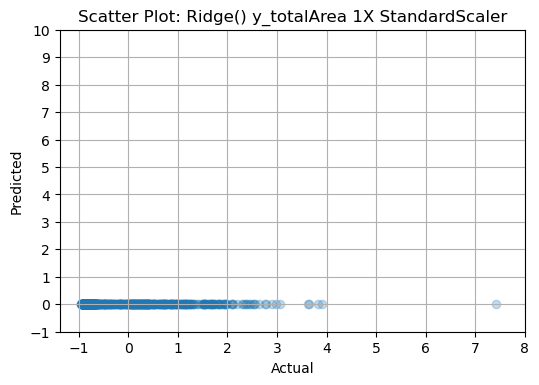

/standardScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.64
Best score in neg_mean_squared_error: -1.02
Best score in r2: -0.19


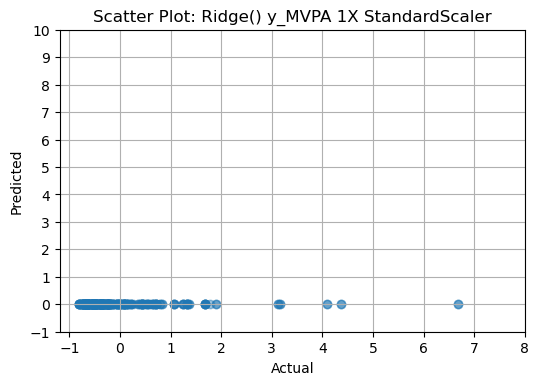

/standardScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.32
Best score in neg_mean_squared_error: -0.25
Best score in r2: 0.74


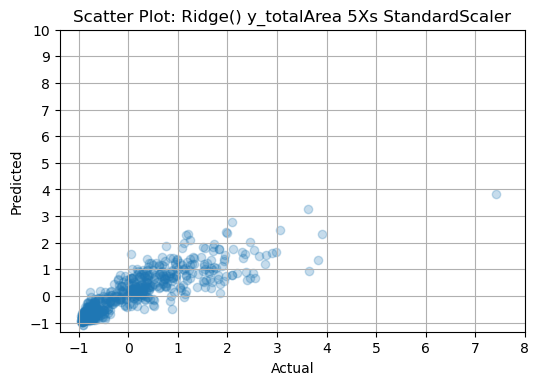

/standardScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.64
Best score in neg_mean_squared_error: -1.02
Best score in r2: -0.19


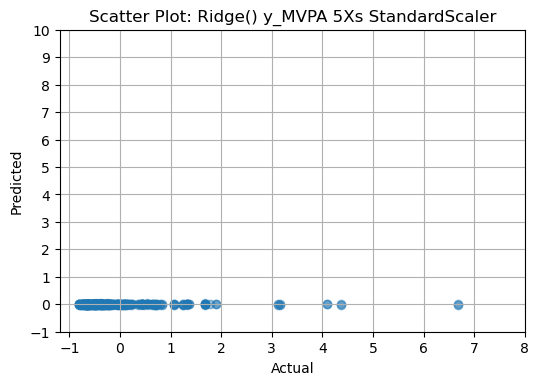

/minMaxScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.01
Best score in r2: -0.06


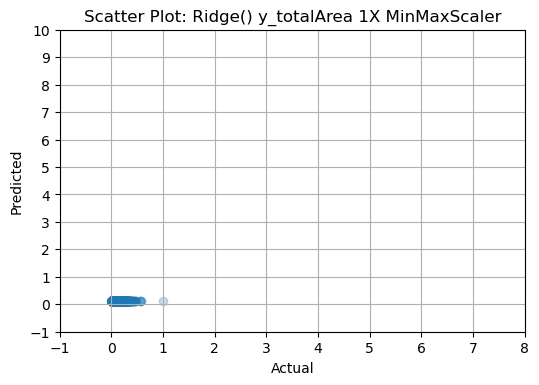

/minMaxScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.19


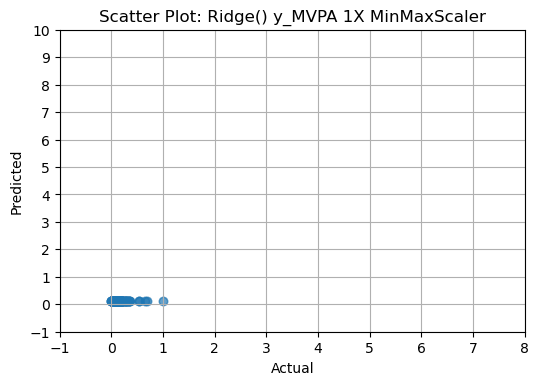

/minMaxScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.04
Best score in neg_mean_squared_error: -0.00
Best score in r2: 0.74


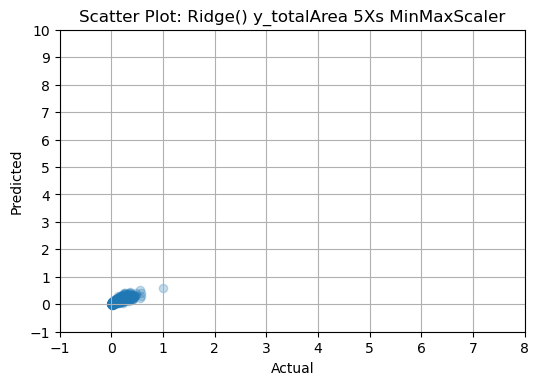

/minMaxScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.19


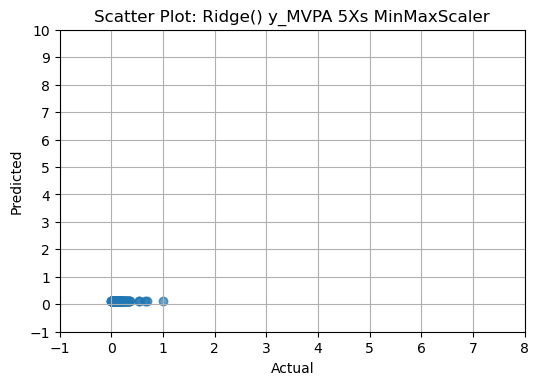


------------------ Kernel Ridge Model ------------------
/standardScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.79
Best score in neg_mean_squared_error: -1.00
Best score in r2: -0.04


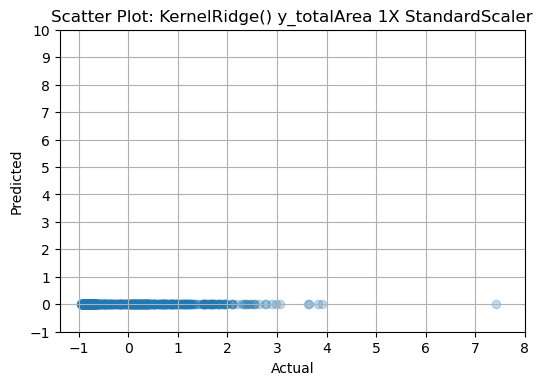

/standardScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.63
Best score in neg_mean_squared_error: -1.00
Best score in r2: -0.15


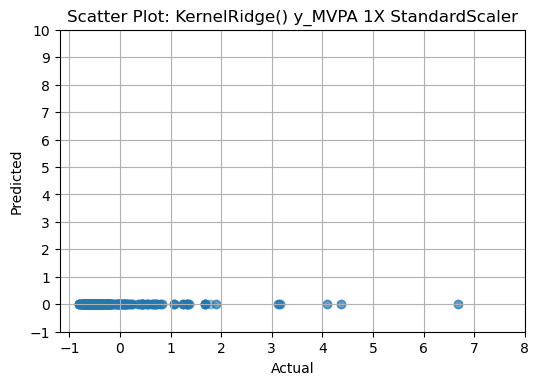

/standardScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.31
Best score in neg_mean_squared_error: -0.22
Best score in r2: 0.76


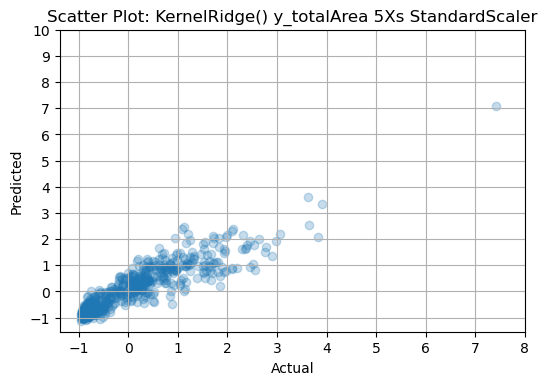

/standardScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.63
Best score in neg_mean_squared_error: -1.00
Best score in r2: -0.15


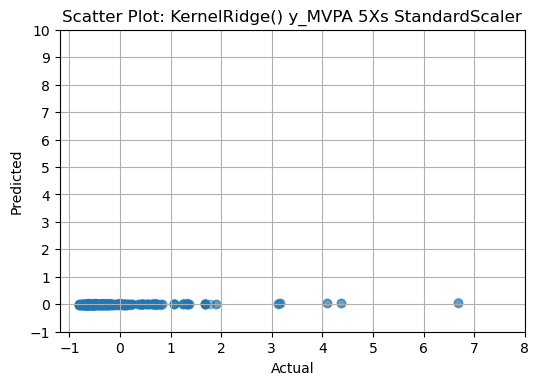

/minMaxScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.01
Best score in r2: -0.05


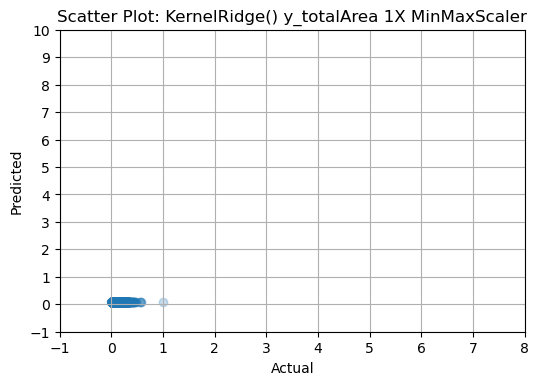

/minMaxScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.08
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.12


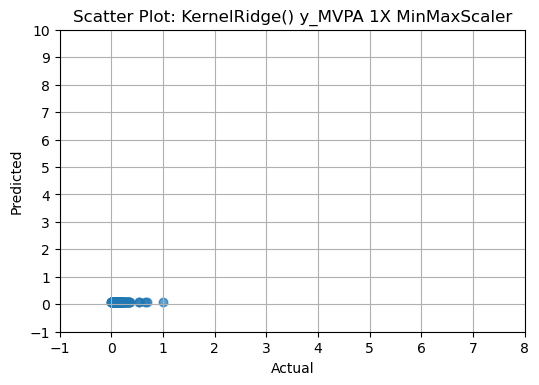

/minMaxScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.04
Best score in neg_mean_squared_error: -0.00
Best score in r2: 0.76


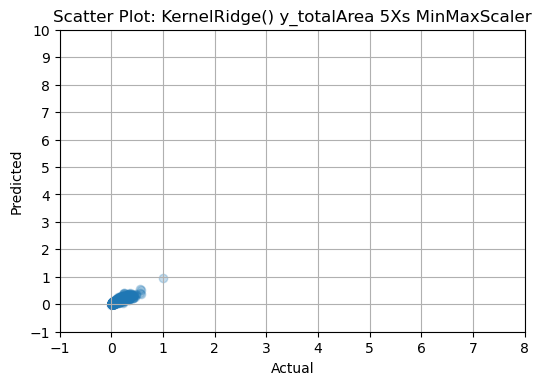

/minMaxScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.08
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.12


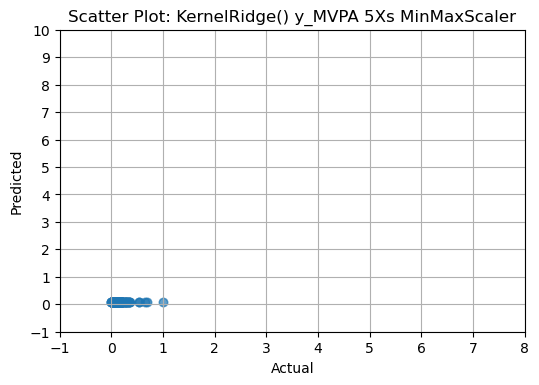


------------------ AdaBoost Model ------------------
/standardScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.79
Best score in neg_mean_squared_error: -1.01
Best score in r2: -0.07


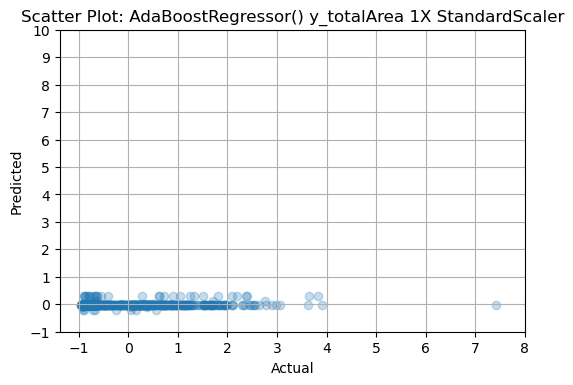

/standardScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.67
Best score in neg_mean_squared_error: -1.08
Best score in r2: -0.26


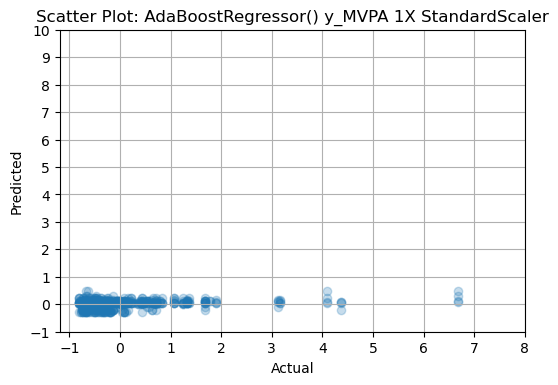

/standardScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.32
Best score in neg_mean_squared_error: -0.27
Best score in r2: 0.72


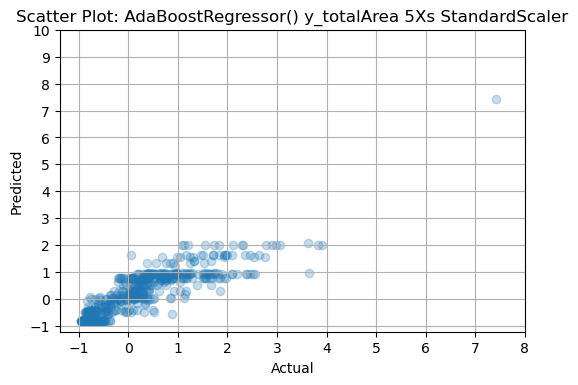

/standardScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.64
Best score in neg_mean_squared_error: -1.08
Best score in r2: -0.24


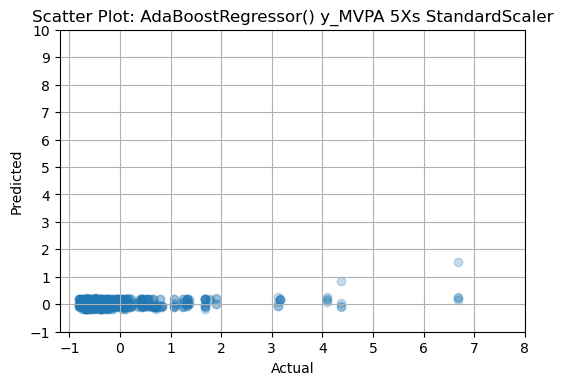

/minMaxScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.01
Best score in r2: -0.08


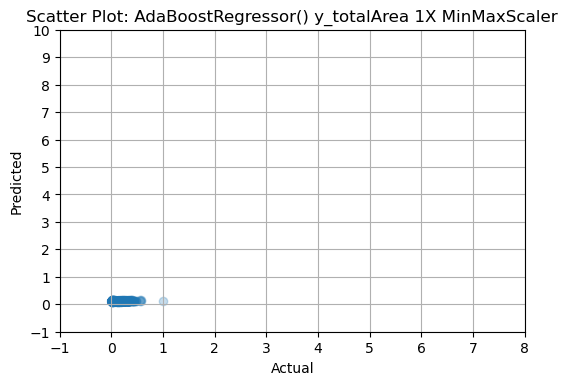

/minMaxScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.34


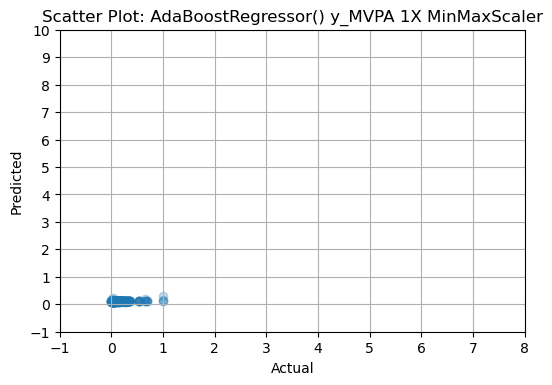

/minMaxScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.04
Best score in neg_mean_squared_error: -0.00
Best score in r2: 0.72


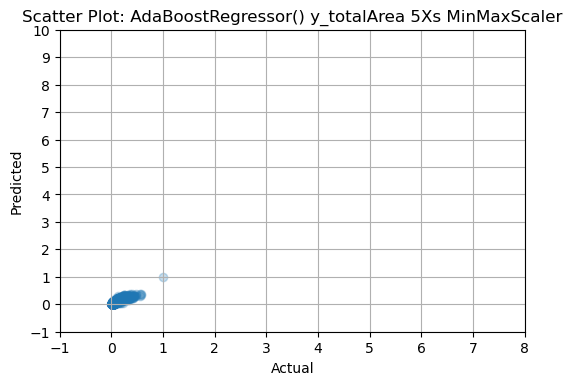

/minMaxScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.08
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.26


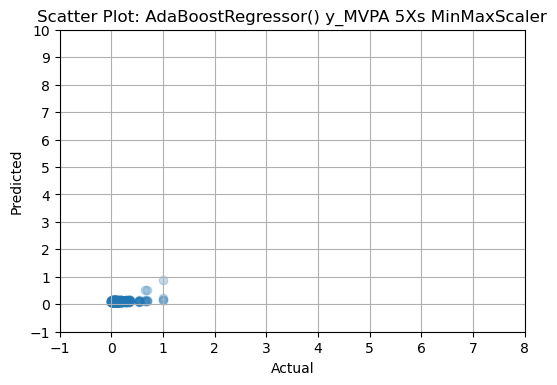


------------------ Random Forest Model ------------------
/standardScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.79
Best score in neg_mean_squared_error: -1.01
Best score in r2: -0.05


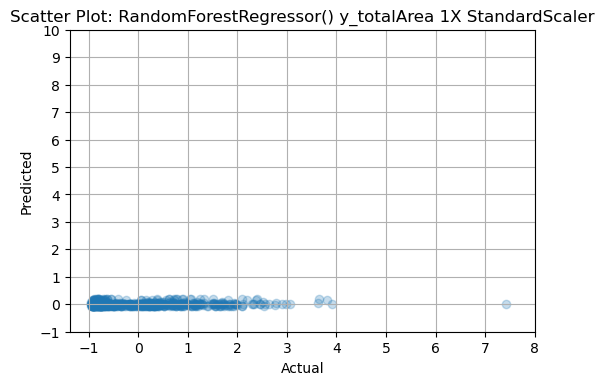

/standardScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.65
Best score in neg_mean_squared_error: -1.02
Best score in r2: -0.20


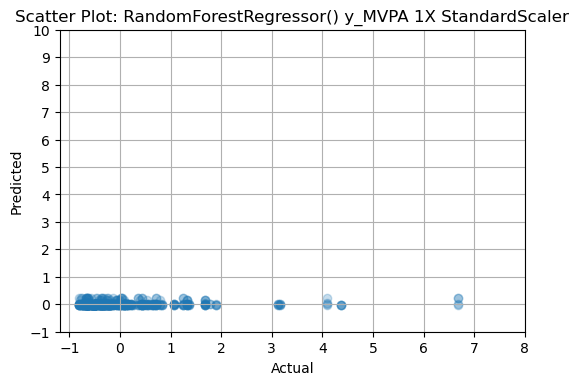

/standardScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.30
Best score in neg_mean_squared_error: -0.23
Best score in r2: 0.76


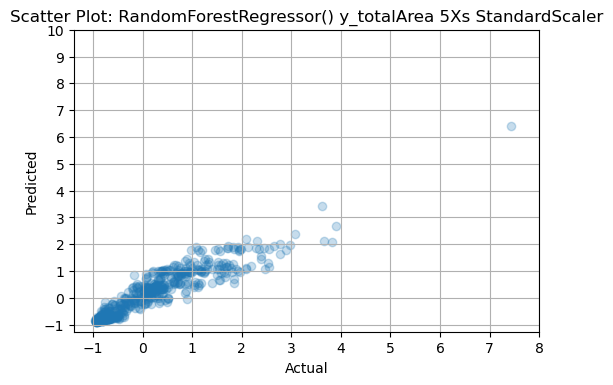

/standardScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.64
Best score in neg_mean_squared_error: -1.01
Best score in r2: -0.18


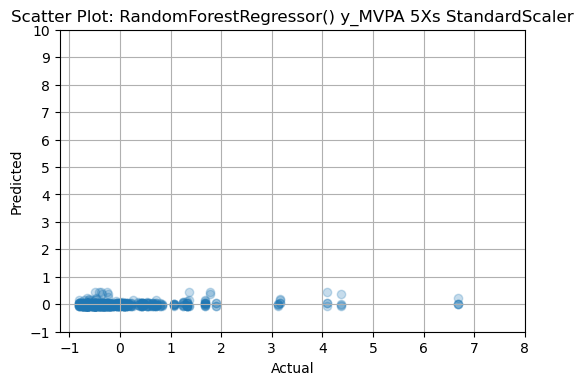

/minMaxScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.01
Best score in r2: -0.05


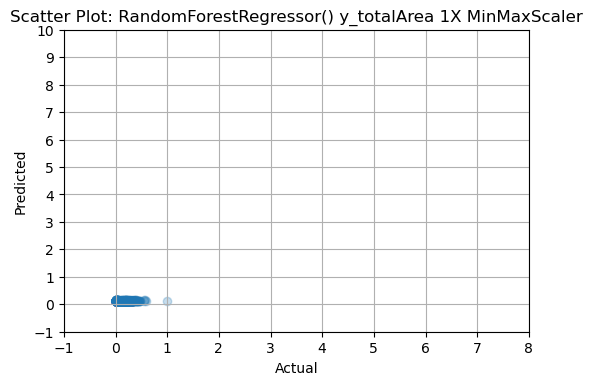

/minMaxScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.19


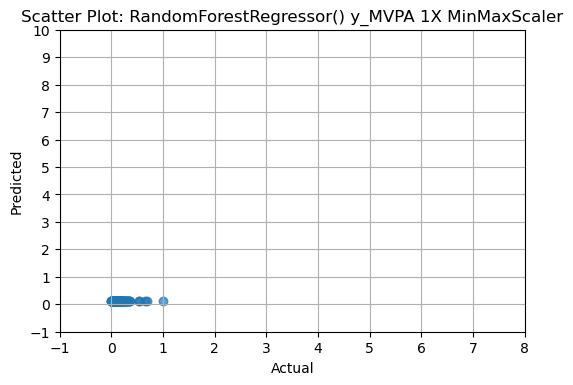

/minMaxScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.04
Best score in neg_mean_squared_error: -0.00
Best score in r2: 0.76


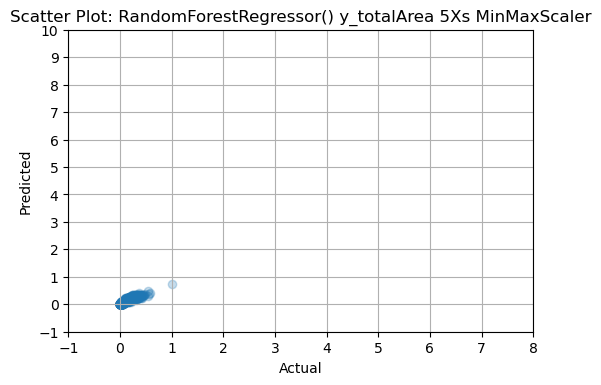

/minMaxScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.08
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.19


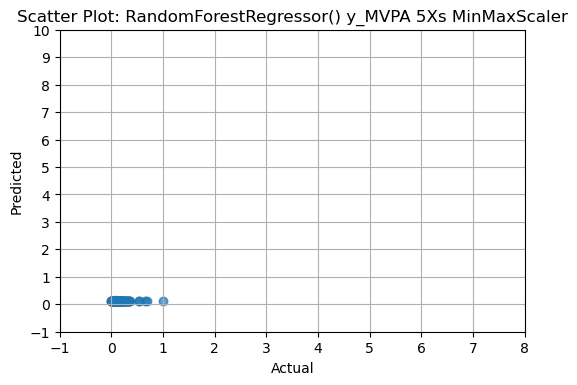


------------------ Neural Network Model ------------------
/standardScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.79
Best score in neg_mean_squared_error: -1.00
Best score in r2: -0.05


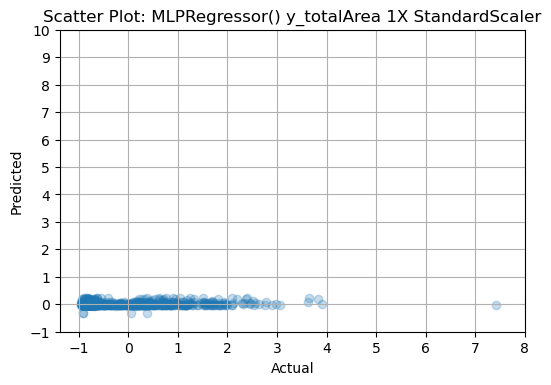

/standardScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.64
Best score in neg_mean_squared_error: -1.02
Best score in r2: -0.19


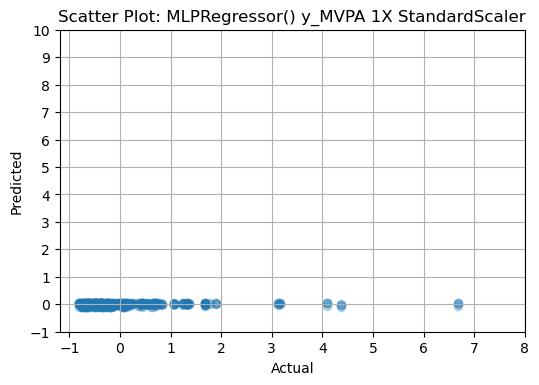

/standardScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.31
Best score in neg_mean_squared_error: -0.22
Best score in r2: 0.75


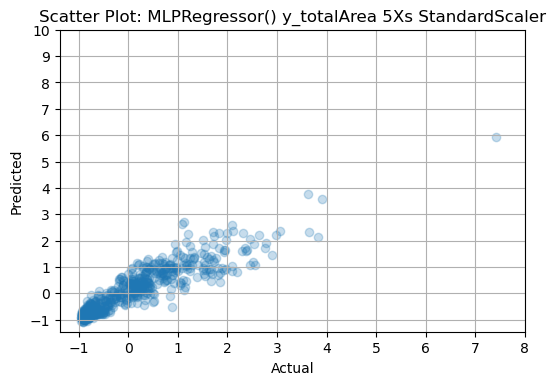

/standardScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.66
Best score in neg_mean_squared_error: -1.12
Best score in r2: -0.38


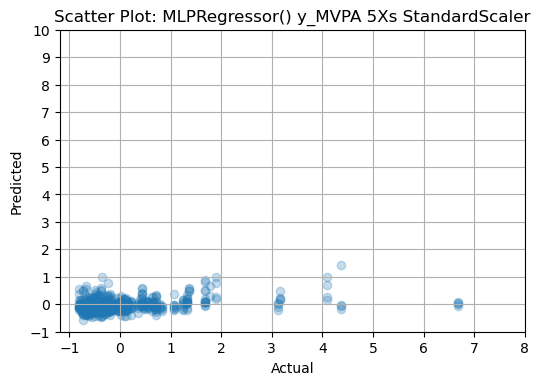

/minMaxScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.01
Best score in r2: -0.04


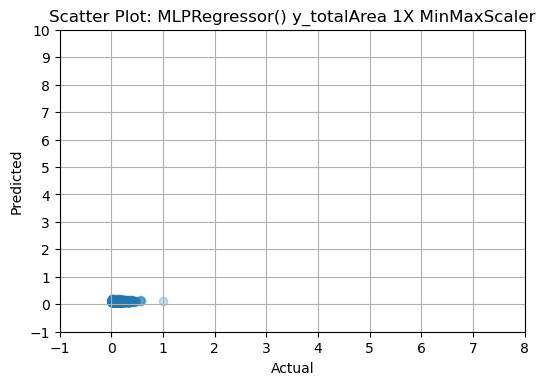

/minMaxScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.08
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.16


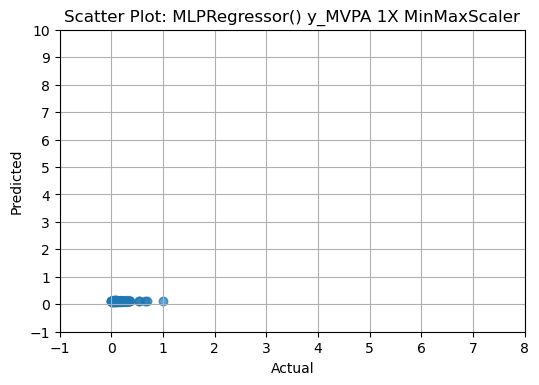

/minMaxScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.04
Best score in neg_mean_squared_error: -0.00
Best score in r2: 0.74


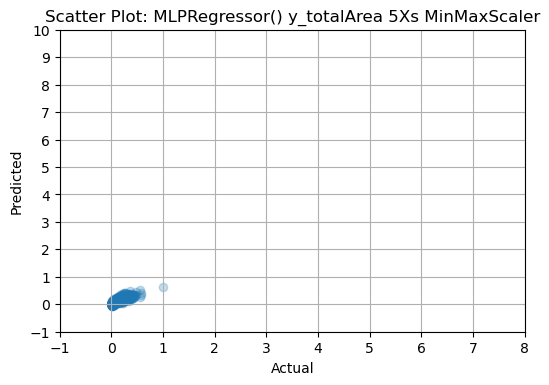

/minMaxScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.21


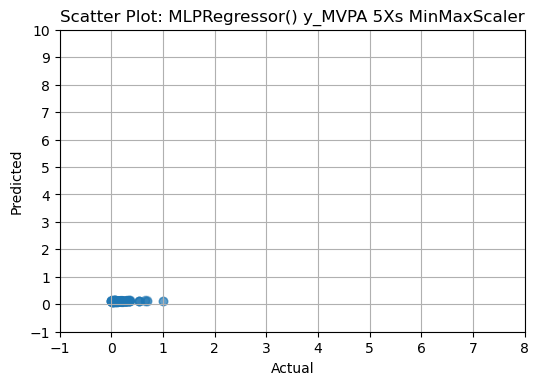


------------------ Support Vector Machine Model ------------------
/standardScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.76
Best score in neg_mean_squared_error: -1.12
Best score in r2: -0.14


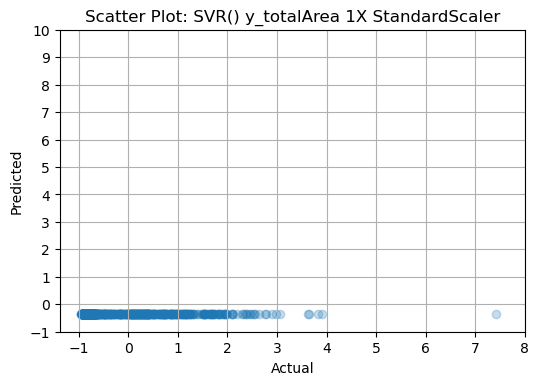

/standardScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.57
Best score in neg_mean_squared_error: -1.11
Best score in r2: -0.16


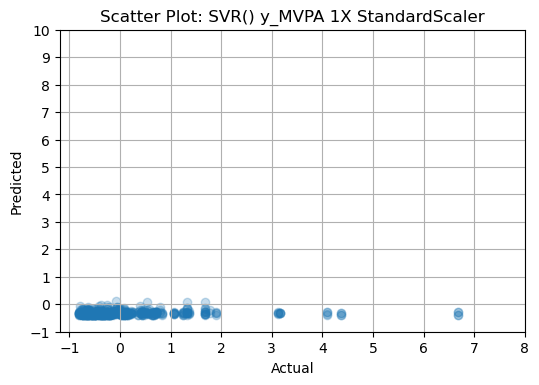

/standardScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.30
Best score in neg_mean_squared_error: -0.23
Best score in r2: 0.75


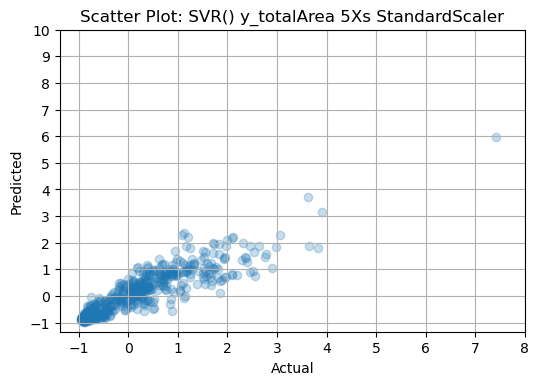

/standardScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.57
Best score in neg_mean_squared_error: -1.08
Best score in r2: -0.16


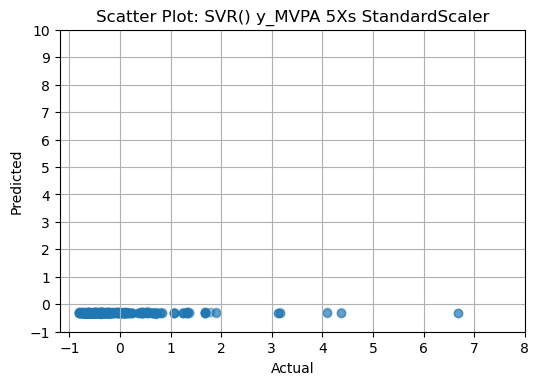

/minMaxScaler/x_MVPA_y_totalArea
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.01
Best score in r2: -0.05


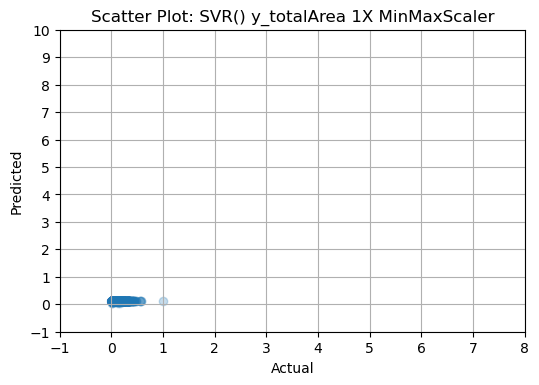

/minMaxScaler/x_totalArea_y_MVPA
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.23


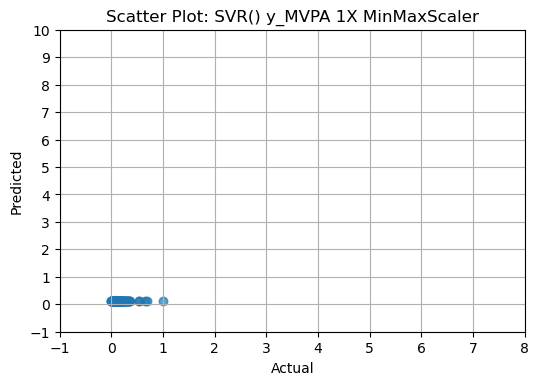

/minMaxScaler/y_totalArea
Best score in neg_mean_absolute_error: -0.05
Best score in neg_mean_squared_error: -0.00
Best score in r2: 0.67


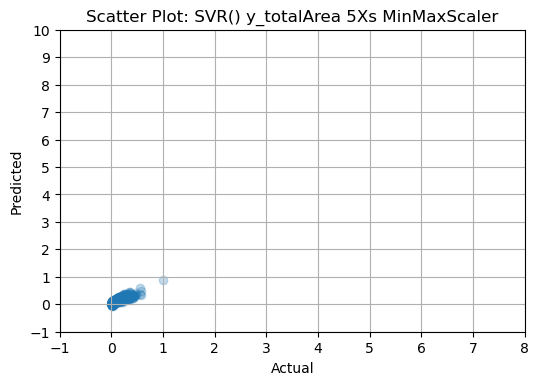

/minMaxScaler/y_MVPA
Best score in neg_mean_absolute_error: -0.09
Best score in neg_mean_squared_error: -0.02
Best score in r2: -0.24


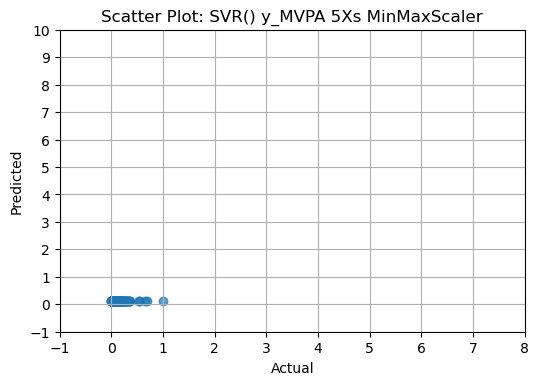

In [5]:
if __name__ == '__main__':
    algs = ['ridge', 'kr', 'ab', 'rf', 'nn', 'svr'] # ['ridge', 'kr', 'ab', 'rf', 'nn', 'svr']
    rules = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'] # ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    
    
    ss = '/standardScaler'
    ss_xlsx = ss+'/standardScaler.xlsx'
    ss_savefiles = [ss+'/y_totalArea_x_MVPA', ss+'/y_MVPA_x_totalArea', ss+'/y_MVPA',
                    ss+'/y_totalArea_x_IPAQ', ss+'/y_IPAQ_x_totalArea', ss+'/y_IPAQ',
                    ss+'/y_totalArea']
    
    mms = '/minMaxScaler'
    mms_xlsx = mms+'/minMaxScaler.xlsx'
    mms_savefiles = [mms+'/y_totalArea_x_MVPA', mms+'/y_MVPA_x_totalArea', mms+'/y_MVPA',
                     mms+'/y_totalArea_x_IPAQ', mms+'/y_IPAQ_x_totalArea', mms+'/y_IPAQ',
                     mms+'/y_totalArea']
    
    rs = '/robustScaler'
    rs_xlsx = mms+'/robustScaler.xlsx'
    rs_savefiles = [mms+'/y_totalArea_x_MVPA', mms+'/y_MVPA_x_totalArea', mms+'/y_MVPA',
                    mms+'/y_totalArea_x_IPAQ', mms+'/y_IPAQ_x_totalArea', mms+'/y_IPAQ',
                    mms+'/y_totalArea']
    
    
    for alg in algs:
        alg_dict = {
            'ridge': 'Ridge',
            'kr': 'Kernel Ridge',
            'svr': 'Support Vector Machine',
            'nn': 'Neural Network',
            'rf': 'Random Forest',
            'ab': 'AdaBoost',
        }
        model = alg_dict.get(alg)
        
        
        print("\n------------------ %s Model ------------------" %model)
        for ss_savefile in ss_savefiles:
            print(ss_savefile)
            for rule in rules:
                test = learning(alg, rule, ss_xlsx, ss_savefile)
                test.gridSearchCV_eval()
                
        for mms_savefile in mms_savefiles:
            print(mms_savefile)
            for rule in rules:
                test = learning(alg, rule, mms_xlsx, mms_savefile)
                test.gridSearchCV_eval()
                
        for rs_savefile in rs_savefiles:
            print(rs_savefile)
            for rule in rules:
                test = learning(alg, rule, rs_xlsx, rs_savefile)
                test.gridSearchCV_eval()

In [62]:
#################
# the following one classe are only for plotting the original data graph
class plot(object):
    
    def __init__(self, loadfile, savefile): # alg = algorithm name, rule = evaluation method
        self.loadfile = loadfile
        self.savefile = savefile

    def param(self):
        i = 1 if ('y_MVPA' in self.savefile) else 0 # check what y sets, MVPA or Total Area
        j = 0 if (('x_MVPA_y_totalArea' in self.savefile) or ('x_totalArea_y_MVPA' in self.savefile)) else 1 # check how many variables in X, 5 or 1
        k = 1 if ('/standardScaler' in self.loadfile) else 0 # check preprocessing method, StandardScaler or MinMaxScaler
        return i, j, k

    # Import dataset
    def loadDatasets(self):
        path = os.getcwd()#get current path
        path_up1Dir = os.path.dirname(path)#go up one directory
        dataset = pd.read_excel(path_up1Dir + self.loadfile)#to import the preprocessed dataset into a variable
        
        i = self.param()[0]
        j = self.param()[1]
        k = self.param()[2]
        
        y = dataset['MVPA_minutes.week'] if (i == 1) else dataset['aveTotalArea']
        if (i == 1):
            X = pd.DataFrame(dataset.loc[:,['aveML_RMS','aveDisplacement','aveVelocity','aveAP_RMS','aveTotalArea']]) if (j == 1) else dataset['aveTotalArea'].values.reshape(-1, 1)
        else:
            X = pd.DataFrame(dataset.loc[:,['aveML_RMS','aveDisplacement','aveVelocity','aveAP_RMS','MVPA_minutes.week']]) if (j == 1) else dataset['MVPA_minutes.week'].values.reshape(-1, 1)
        
        return X, y, path_up1Dir
    
    def scatter(self):
        i = self.param()[0]
        j = self.param()[1]
        k = self.param()[2]
        
        i_ = 'y_MVPA' if (i == 1) else 'y_totalArea'
        j_ = '5Xs' if (j == 1) else '1X'
        k_ = 'StandardScaler' if (k == 1) else 'MinMaxScaler'
        
        X = self.loadDatasets()[0]
        y = self.loadDatasets()[1]

#         plt.figure(dpi=300)
        plt.title("Scatter Plot: original X vs y %s %s" %(i_, j_))
        if (j == 1):
            indexs = np.arange(0,5)
            color_dict = {0:'yellow', 1:'cyan', 2:'lime', 3:'violet', 4:'pink',}
            marker_dict = {0:'s', 1:'^', 2:'*', 3:'d', 4:'x',}
            
            for index in indexs:              
                X_ = X.iloc[:,index]
                c = color_dict.get(index)
                m = marker_dict.get(index)
                min_ = [X_.min(), y.min()]
                max_ = [X_.max(), y.max()]
                
                print(min_, max_)
                plt.plot(min_, max_, color=c, linewidth=3)
                plt.scatter(x=X_.min(), y=y.min(), color='blue', marker='o')
                plt.scatter(x=X_.mean(), y=y.mean(), color='fuchsia', marker='o')
                plt.scatter(x=X_.max(), y=y.max(), color='purple', marker='o')
                plt.scatter(x=X_.std(), y=y.std(), color='green', marker='o')
                plt.scatter(x=X_, y=y, alpha=0.3, color=c, label=X.columns[index], marker=m)
            plt.xlabel(j_) 
            plt.ylabel(i_)
            plt.xlim(xmin=-2, xmax=100)
    #         plt.xticks(range(0,101,10)) if (i==1) else plt.xticks(range(0,1001,100))
    #         plt.xlim(xmin=-2, xmax=100) if (i==1) else plt.xlim(xmin=-10, xmax=310)
            plt.grid(True)
            plt.legend()
            #plt.savefig(fname=self.loadDatasets()[2] + "/original/scatter_original_data_%s_%s.png" %(i_, j_))
            plt.show()
        else:
#             print(X.min(), X.max(), y.min(), y.max())
#             plt.plot(min_, max_, linewidth=3)
#             plt.scatter(x=X.min(), y=y.min(), alpha=0.5, marker='o')
#             plt.scatter(x=X.mean(), y=y.mean(), alpha=0.5, marker='o')
#             plt.scatter(x=X.max(), y=y.max(), alpha=0.5, marker='o')
#             plt.scatter(x=X.std(), y=y.std(), alpha=0.5, marker='o')
#             plt.scatter(x=X, y=y, alpha=0.2, label='x_totalArea' if (i == 1) else ('x_MVPA'))
        
#         plt.xlabel(j_) 
#         plt.ylabel(i_)
#         plt.xlim(xmin=-2, xmax=100)
# #         plt.xticks(range(0,101,10)) if (i==1) else plt.xticks(range(0,1001,100))
# #         plt.xlim(xmin=-2, xmax=100) if (i==1) else plt.xlim(xmin=-10, xmax=310)
#         plt.grid(True)
#         plt.legend()
#         #plt.savefig(fname=self.loadDatasets()[2] + "/original/scatter_original_data_%s_%s.png" %(i_, j_))
#         plt.show()

In [26]:
# To output the original data graph
class plot1(object):
    
    def __init__(self, check, loadfile, savefile):
        self.check = check
        self.loadfile = loadfile
        self.savefile = savefile
    
    def param(self):
        i = 1 if ('y_MVPA' in self.check) else (2 if 'y_IPAQ' in self.check else 0) # check what y sets: Total Area(0) vs MVPA(1) vs IPAQ(2).
        j = 0 if ('_x' in self.check) else 1 # check how many variables in X: 1(0) vs 5/6(1).
        return i, j
    
    # Import dataset
    def loadDatasets(self):
        path = os.getcwd()#get current path
        path_project = os.path.dirname(path)#go up one directory
        dataset = pd.read_excel(path_project+self.loadfile)#to import the preprocessed dataset into a variable
        
        i = self.param()[0]
        j = self.param()[1]
        
        y = dataset['MVPA_minutes.week'] if i == 1 else (dataset['IPAQ_Category'] if i == 2 else dataset['aveTotalArea'])
        if (i == 0):
            if (j == 1):
                X = pd.DataFrame(dataset.loc[:,['aveML_RMS','aveDisplacement','aveVelocity','aveAP_RMS','MVPA_minutes.week', 'IPAQ_Category']])
            else:
                X = dataset['MVPA_minutes.week'].values.reshape(-1, 1) if ('x_MVPA' in self.check) else dataset['IPAQ_Category'].values.reshape(-1, 1)
        else:
            X = pd.DataFrame(dataset.loc[:,['aveML_RMS','aveDisplacement','aveVelocity','aveAP_RMS','aveTotalArea']]) if j == 1 else dataset['aveTotalArea'].values.reshape(-1, 1)
        
        return X, y, path_project
    
    def scatter(self):
        i = self.param()[0]
        j = self.param()[1]
        X = self.loadDatasets()[0]
        y = self.loadDatasets()[1]
        path_project = self.loadDatasets()[2]
        
        plt.figure(dpi=300)
        plt.title("Scatter Plot: original %s" %self.check)
        indexs = np.arange(0,6) if ((j == 1) and (i == 0)) else (np.arange(0,5) if j == 1 else [0])
        color_dict = {0:'yellow', 1:'cyan', 2:'lime', 3:'violet', 4:'pink', 5:'lightgray',}
        color_dict_dark = {0:'gold', 1:'blue', 2:'green', 3:'m', 4:'fuchsia', 5:'darkgray',}
        marker_dict = {0:'s', 1:'^', 2:'*', 3:'d', 4:'x', 5:'1',}

        for index in indexs:
            X_ = X.iloc[:,index] if j == 1 else X
            c = color_dict.get(index)
            c_dark = color_dict_dark.get(index)
            m = marker_dict.get(index)
            min_ = [X_.min(), y.min()]
            max_ = [X_.max(), y.max()]
            x_ = [X_.min(), X_.max()]
            y_ = [y.min(), y.max()]
            
            print('\nRange: x=%s y=%s' %(x_, y_))
            plt.plot(x_, y_, color=c_dark, alpha=1, linewidth=1)
            plt.scatter(x=X_.mean(), y=y.mean(), color=c_dark, marker=m, linewidths=3)
            print('\nMean: x=%s y=%s' %(X_.mean(), y.mean()))
            print('\nSTD: x=%s y=%s' %(X_.std(), y.std()))
            plt.scatter(x=min_[0], y=min_[1], alpha=0.3, color=c, marker=m)
            if (j == 1):
                plt.scatter(x=max_[0], y=max_[1], alpha=0.3, color=c, label=X.columns[index], marker=m)
            else:
                plt.scatter(x=max_[0], y=max_[1], alpha=0.3, color=c, marker=m)
            
        plt.ylabel('MVPA') if i == 1 else (plt.ylabel('IPAQ') if i == 2 else plt.ylabel('Total Area'))
        
        if (i == 0):
            if (j == 1):
                plt.xlabel('6Xs')
            else:
                plt.xlabel('MVPA') if ('x_MVPA' in self.check) else plt.xlabel('IPAQ')
        else:
            plt.xlabel('Total Area') if j == 0 else plt.xlabel('5Xs')
     
        plt.grid(True)
        plt.legend()
        plt.savefig(path_project+'/original/scatter_0_original_%s.png' %self.check)
        plt.show()
         
        plt.figure(dpi=300)
        for index in indexs:
            X_ = X.iloc[:,index] if j == 1 else X
            c = color_dict.get(index)
            m = marker_dict.get(index)
            plt.scatter(x=X_, y=y, alpha=0.2, color=c, marker=m)

        plt.ylabel('MVPA') if i == 1 else (plt.ylabel('IPAQ') if i == 2 else plt.ylabel('Total Area'))
        if (i == 0):
            if (j == 1):
                plt.xlabel('6Xs')
            else:
                plt.xlabel('MVPA') if ('x_MVPA' in self.check) else plt.xlabel('IPAQ')
        else:
            plt.xlabel('Total Area') if j == 0 else plt.xlabel('5Xs')
        
        plt.grid(True)
        plt.savefig(path_project+'/original/scatter_1_original_%s.png' %self.check)
        plt.show()


------------------ y_totalArea_x_MVPA ------------------


No handles with labels found to put in legend.



Range: x=[0, 5040] y=[0.4102078939927178, 88.87804643616839]

Mean: x=550.875 y=10.570342308076757

STD: x=673.0593747025592 y=10.572839255279332


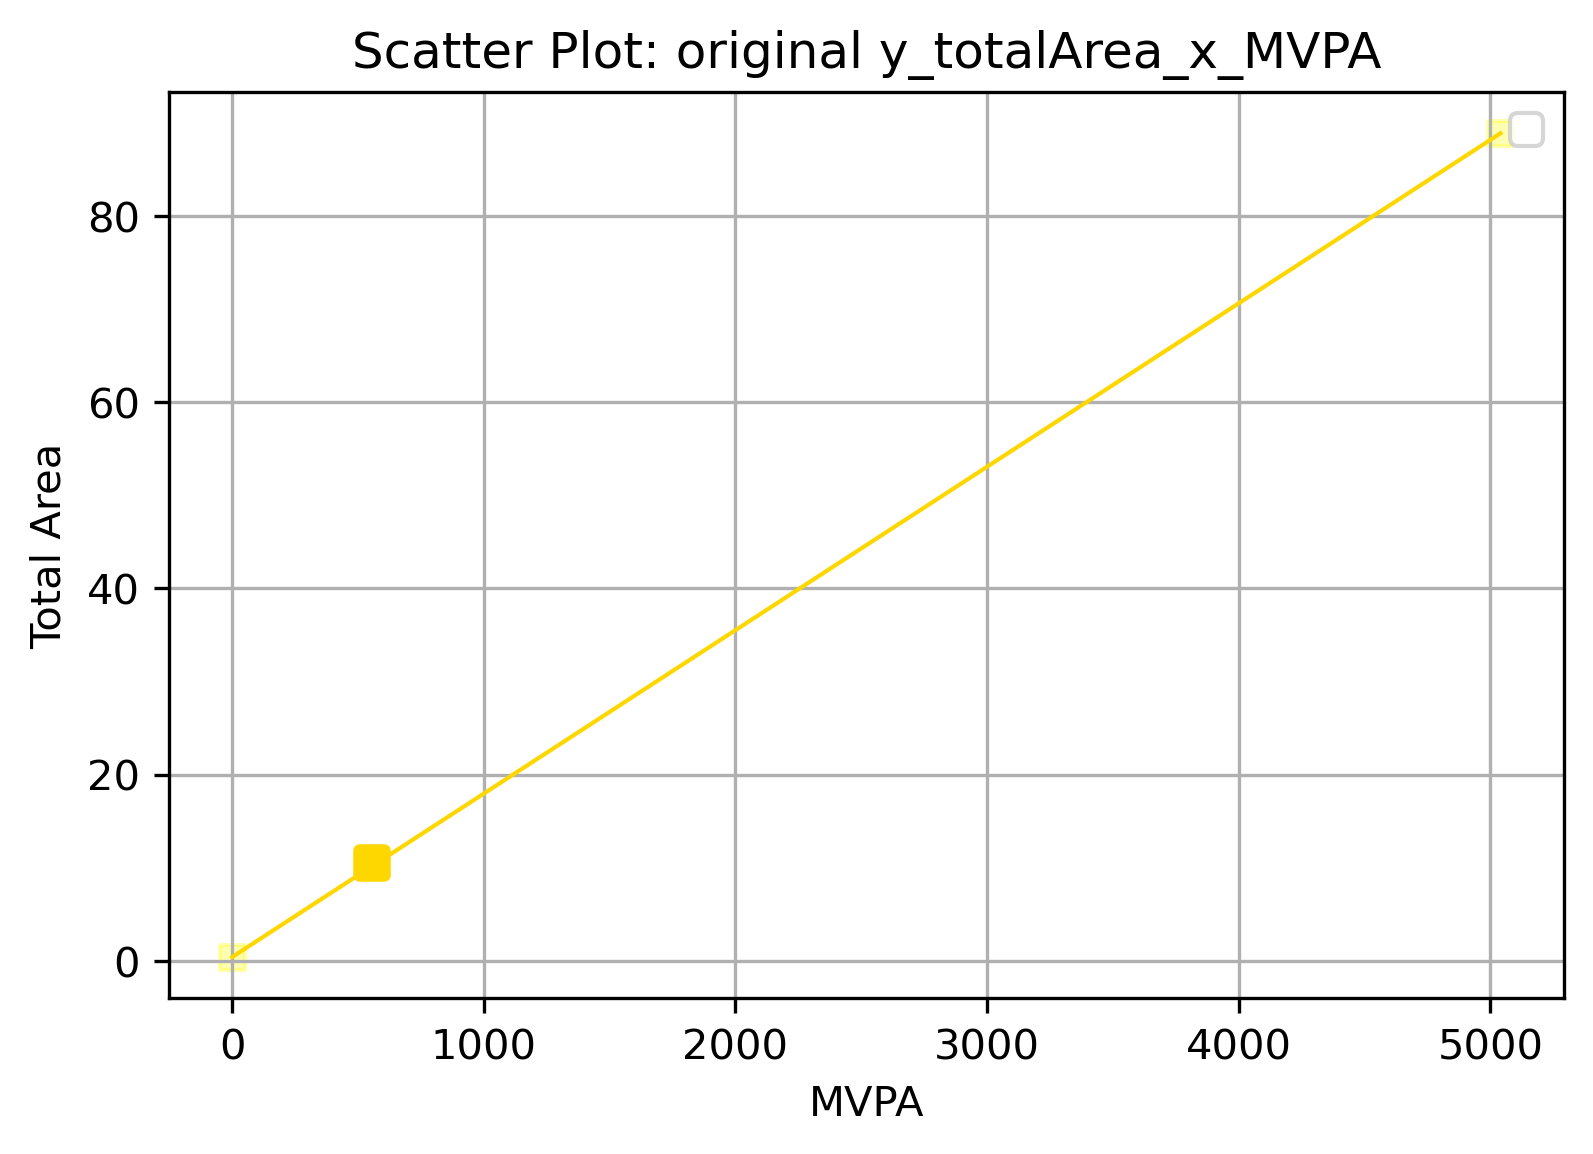

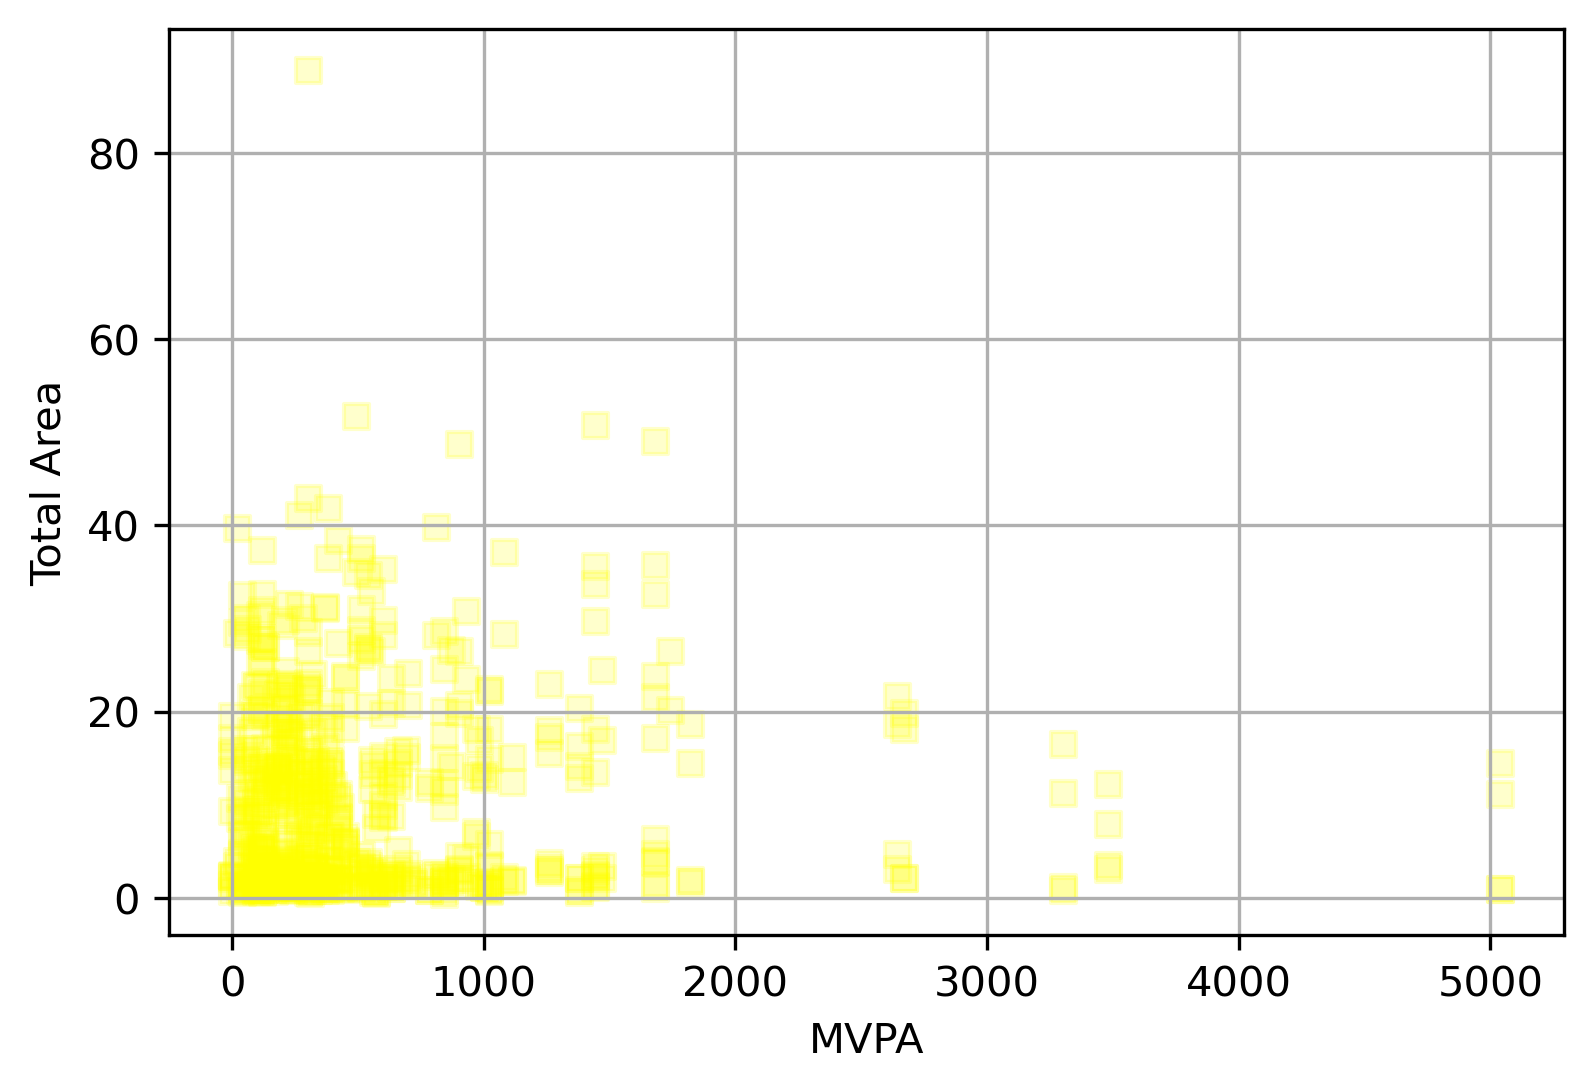


------------------ y_MVPA_x_totalArea ------------------


No handles with labels found to put in legend.



Range: x=[0.4102078939927178, 88.87804643616839] y=[0, 5040]

Mean: x=10.57034230807675 y=550.875

STD: x=10.564575995513435 y=673.5858193467549


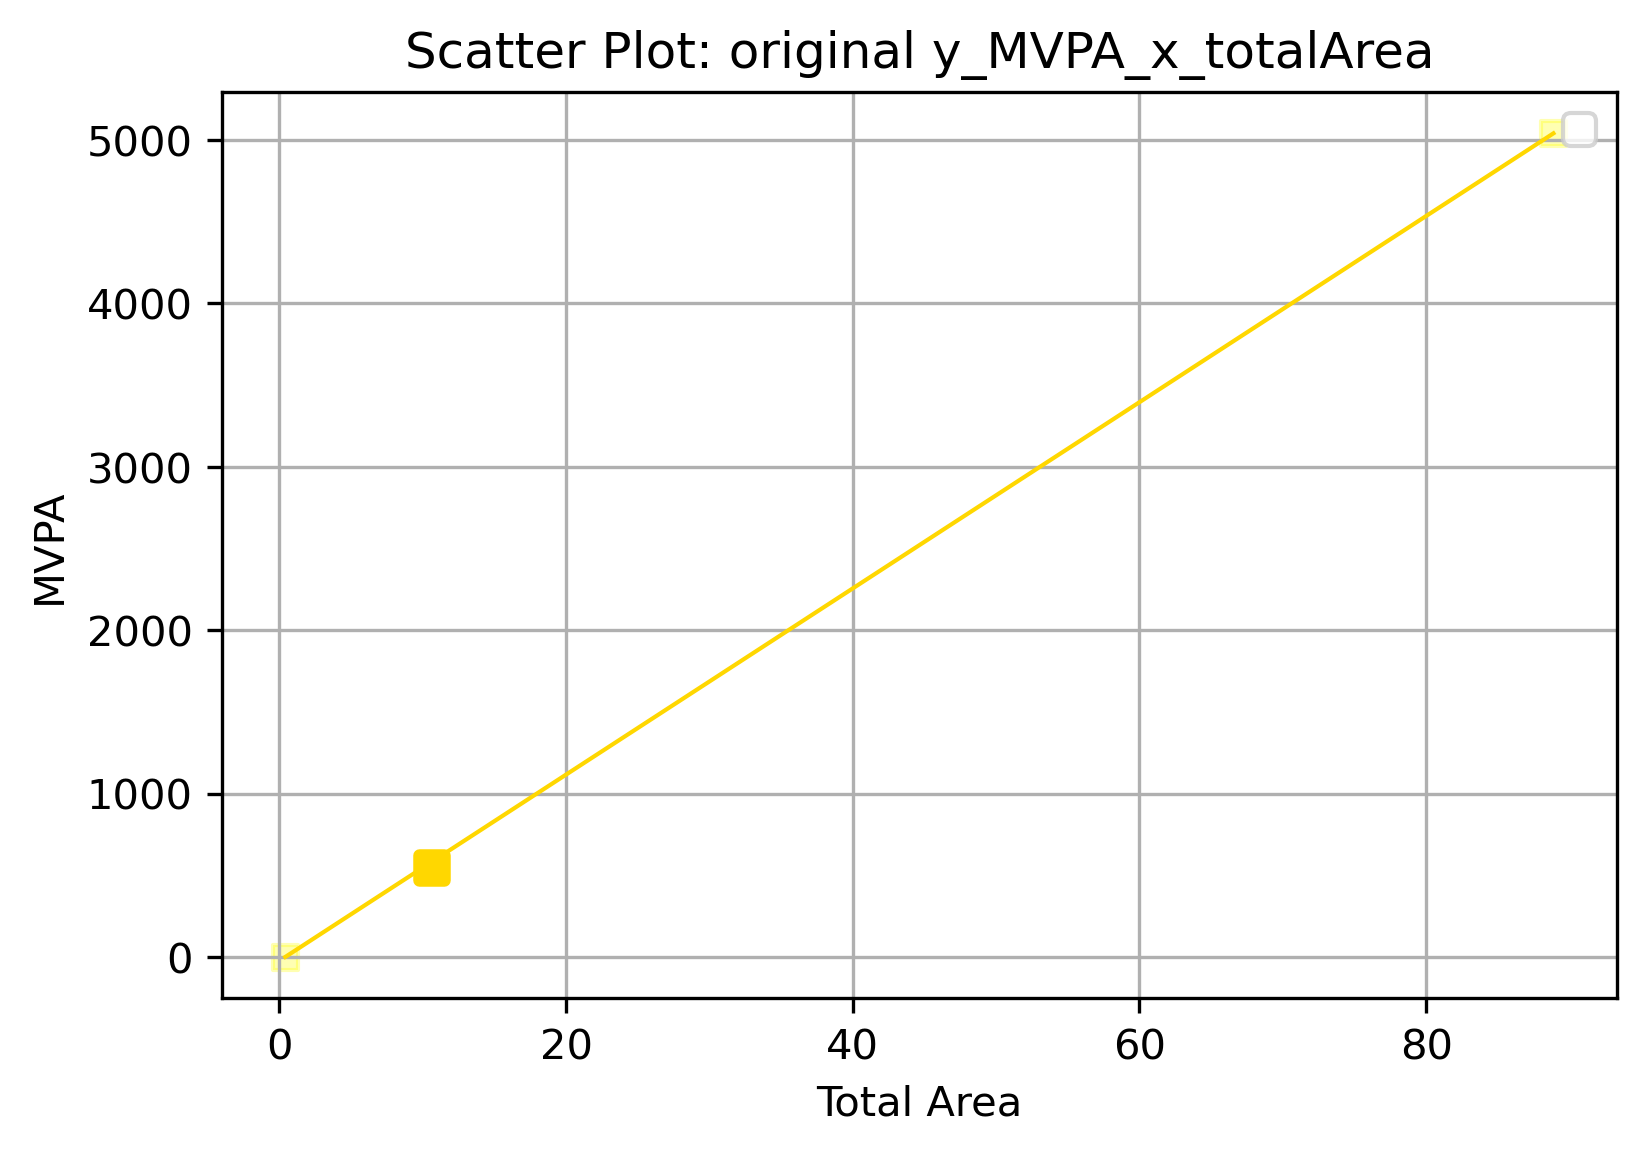

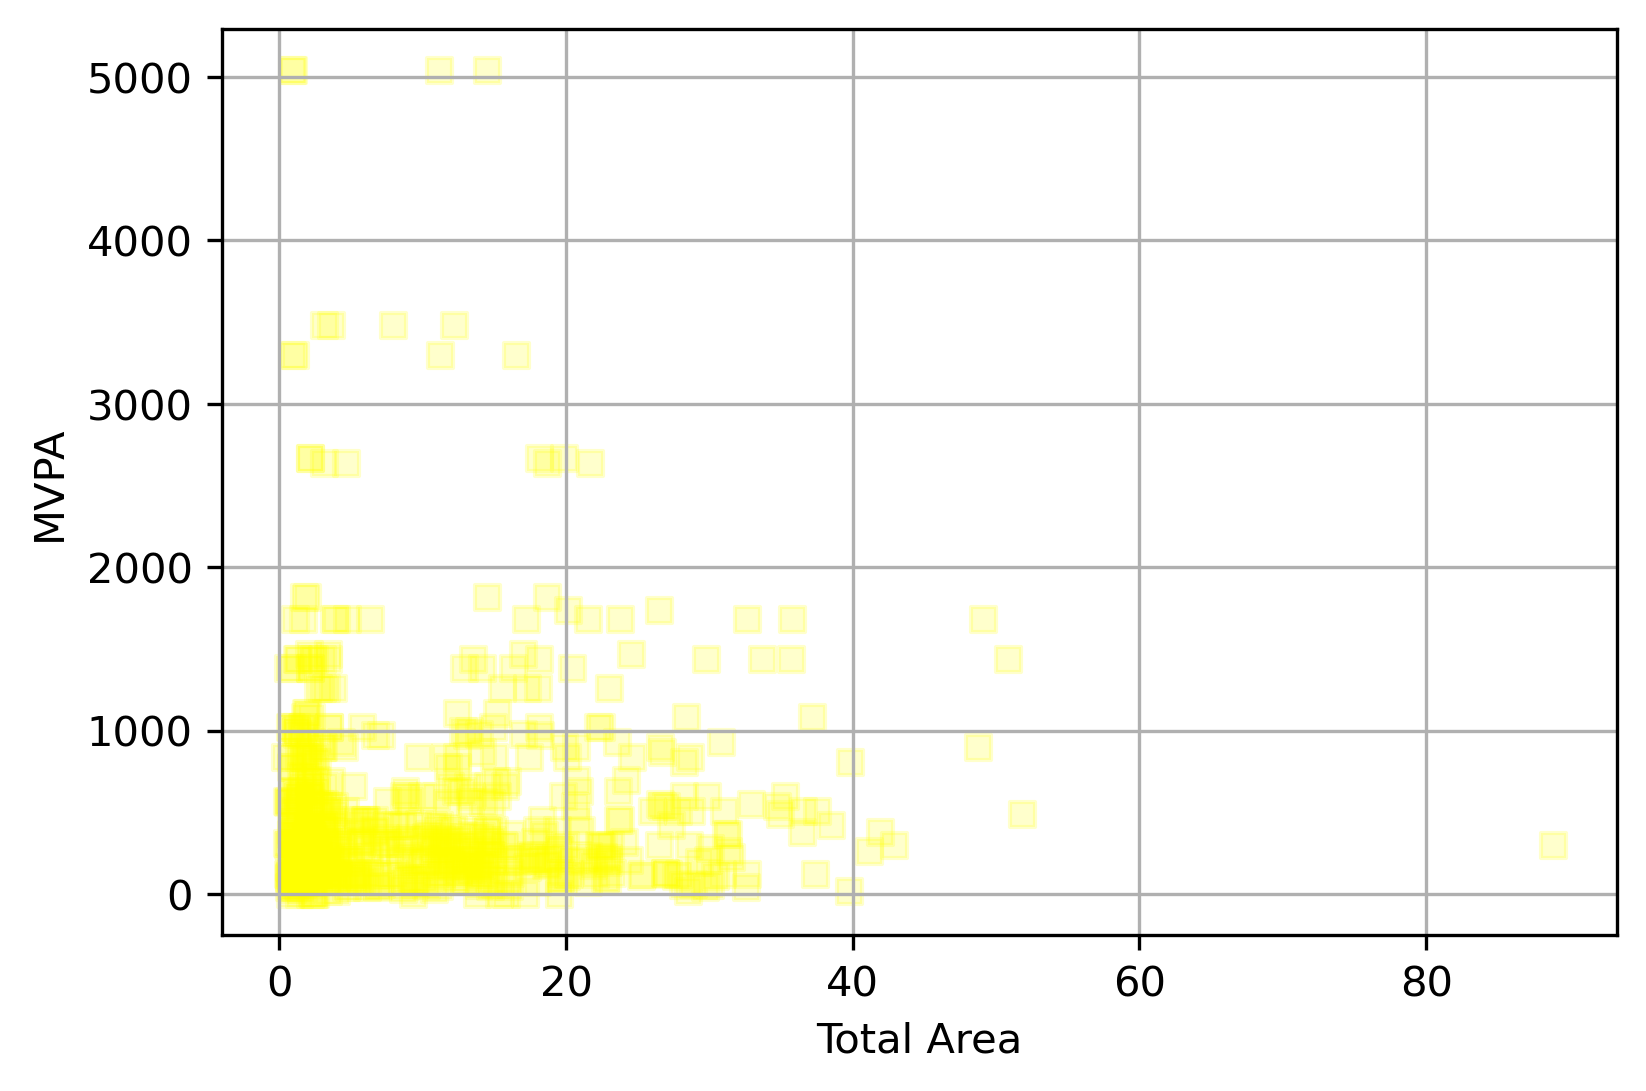


------------------ y_MVPA ------------------

Range: x=[0.1405488996666666, 3.897583579277778] y=[0, 5040]

Mean: x=1.0384700685459198 y=550.875

STD: x=0.6607561779845109 y=673.5858193467549

Range: x=[26.01134630582536, 541.4482963049761] y=[0, 5040]

Mean: x=131.0218621588279 y=550.875

STD: x=86.38056683338019 y=673.5858193467549

Range: x=[0.4335947042144584, 9.025642545507186] y=[0, 5040]

Mean: x=2.1840617129326185 y=550.875

STD: x=1.4399160999063207 y=673.5858193467549

Range: x=[0.347529162, 9.292425413222222] y=[0, 5040]

Mean: x=1.9422836695060746 y=550.875

STD: x=1.2368485414132397 y=673.5858193467549

Range: x=[0.4102078939927178, 88.87804643616839] y=[0, 5040]

Mean: x=10.570342308076757 y=550.875

STD: x=10.572839255279332 y=673.5858193467549


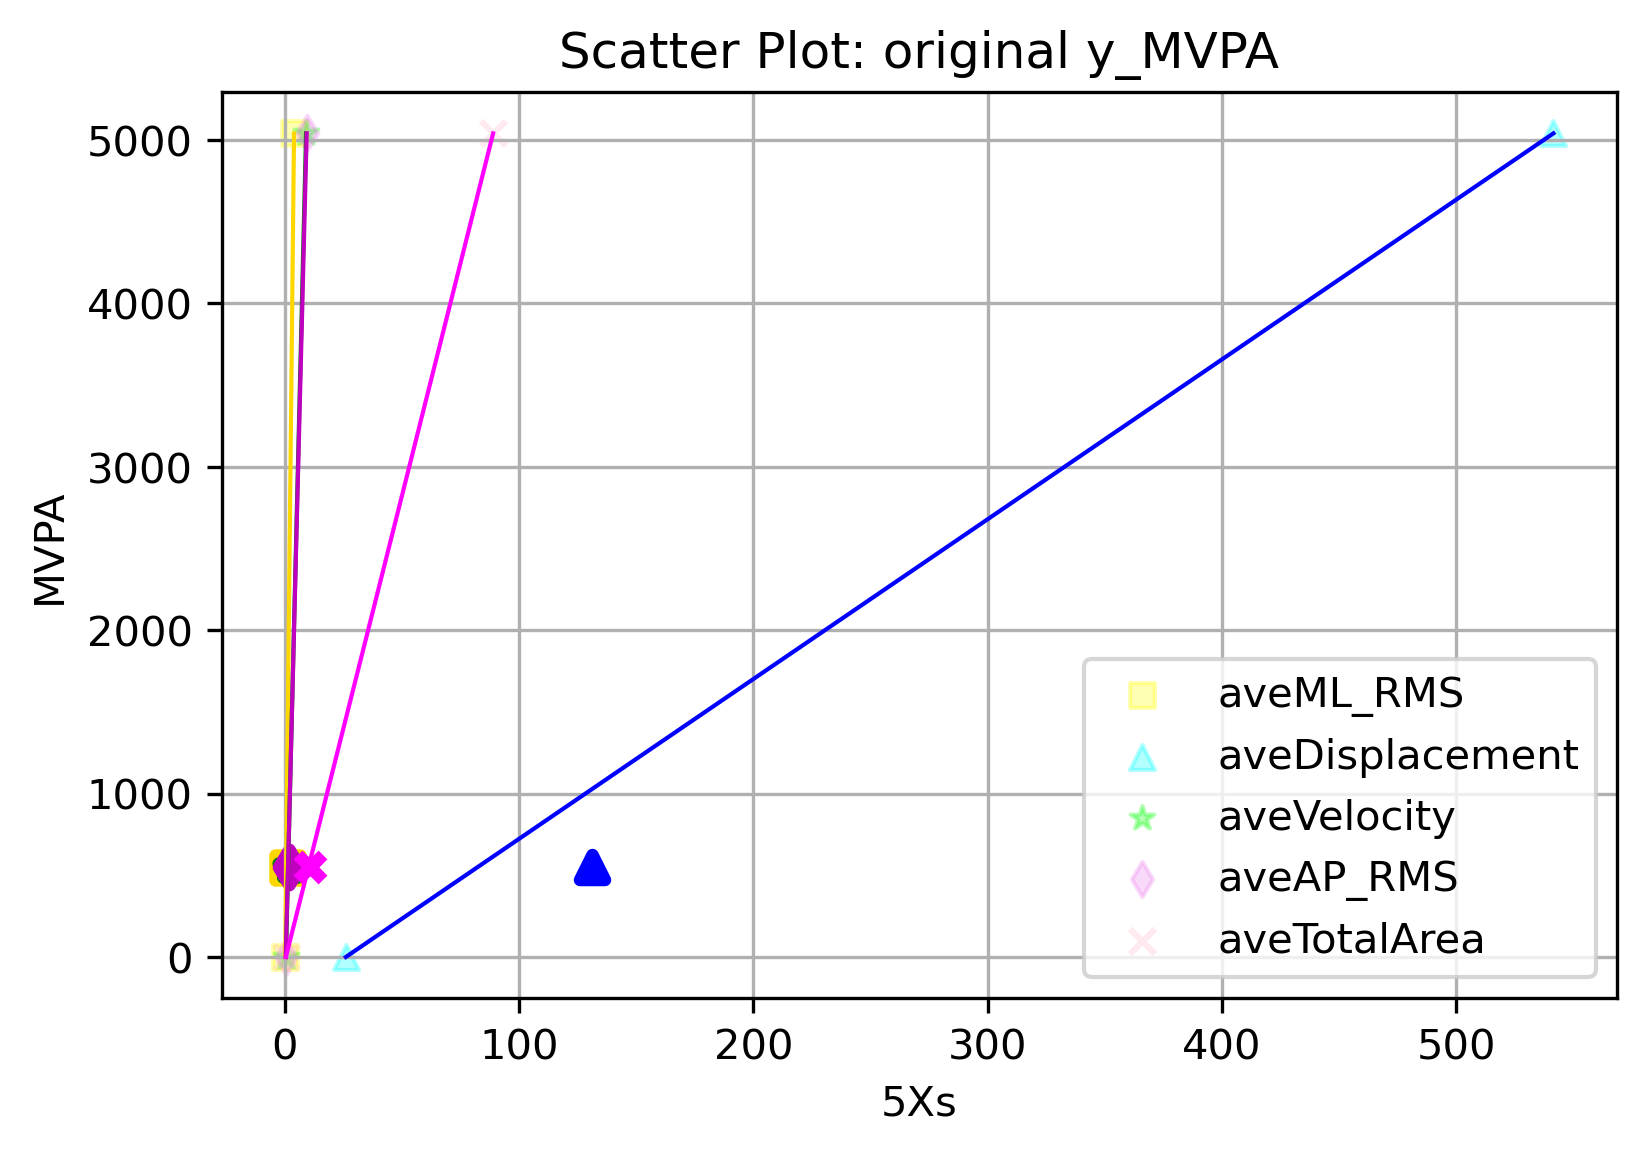

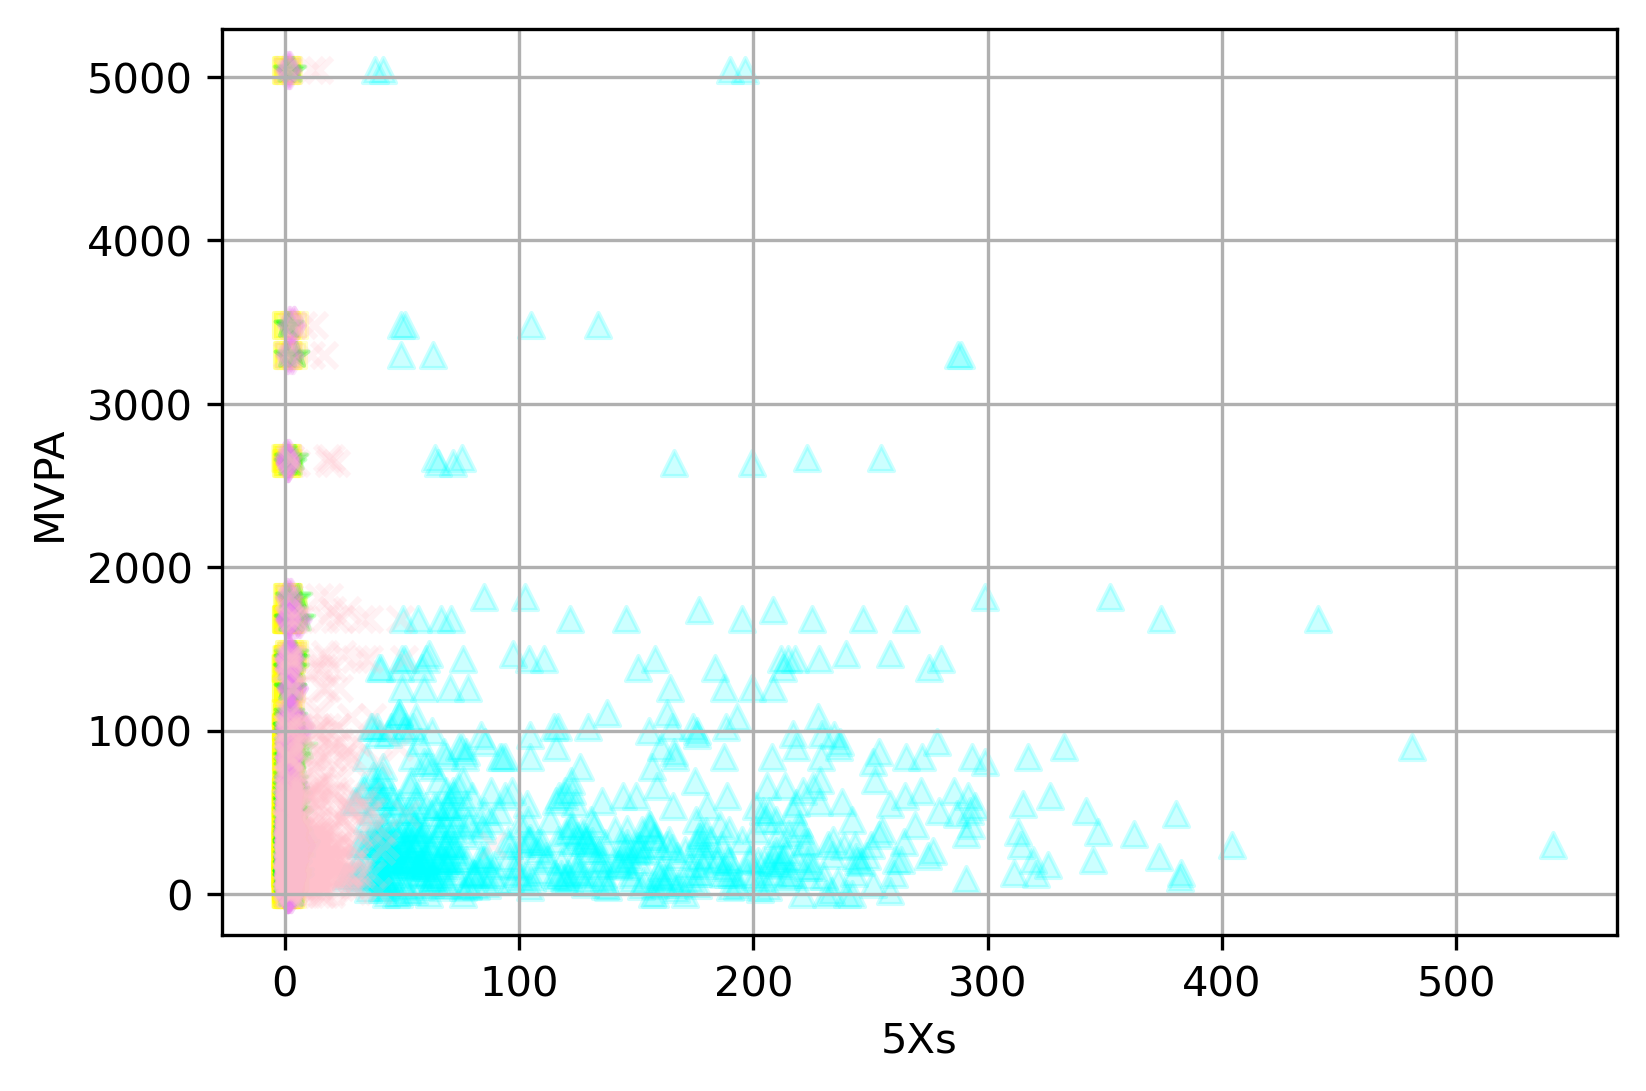


------------------ y_totalArea_x_IPAQ ------------------


No handles with labels found to put in legend.



Range: x=[1, 3] y=[0.4102078939927178, 88.87804643616839]

Mean: x=2.5 y=10.570342308076757

STD: x=0.7310095758606723 y=10.572839255279332


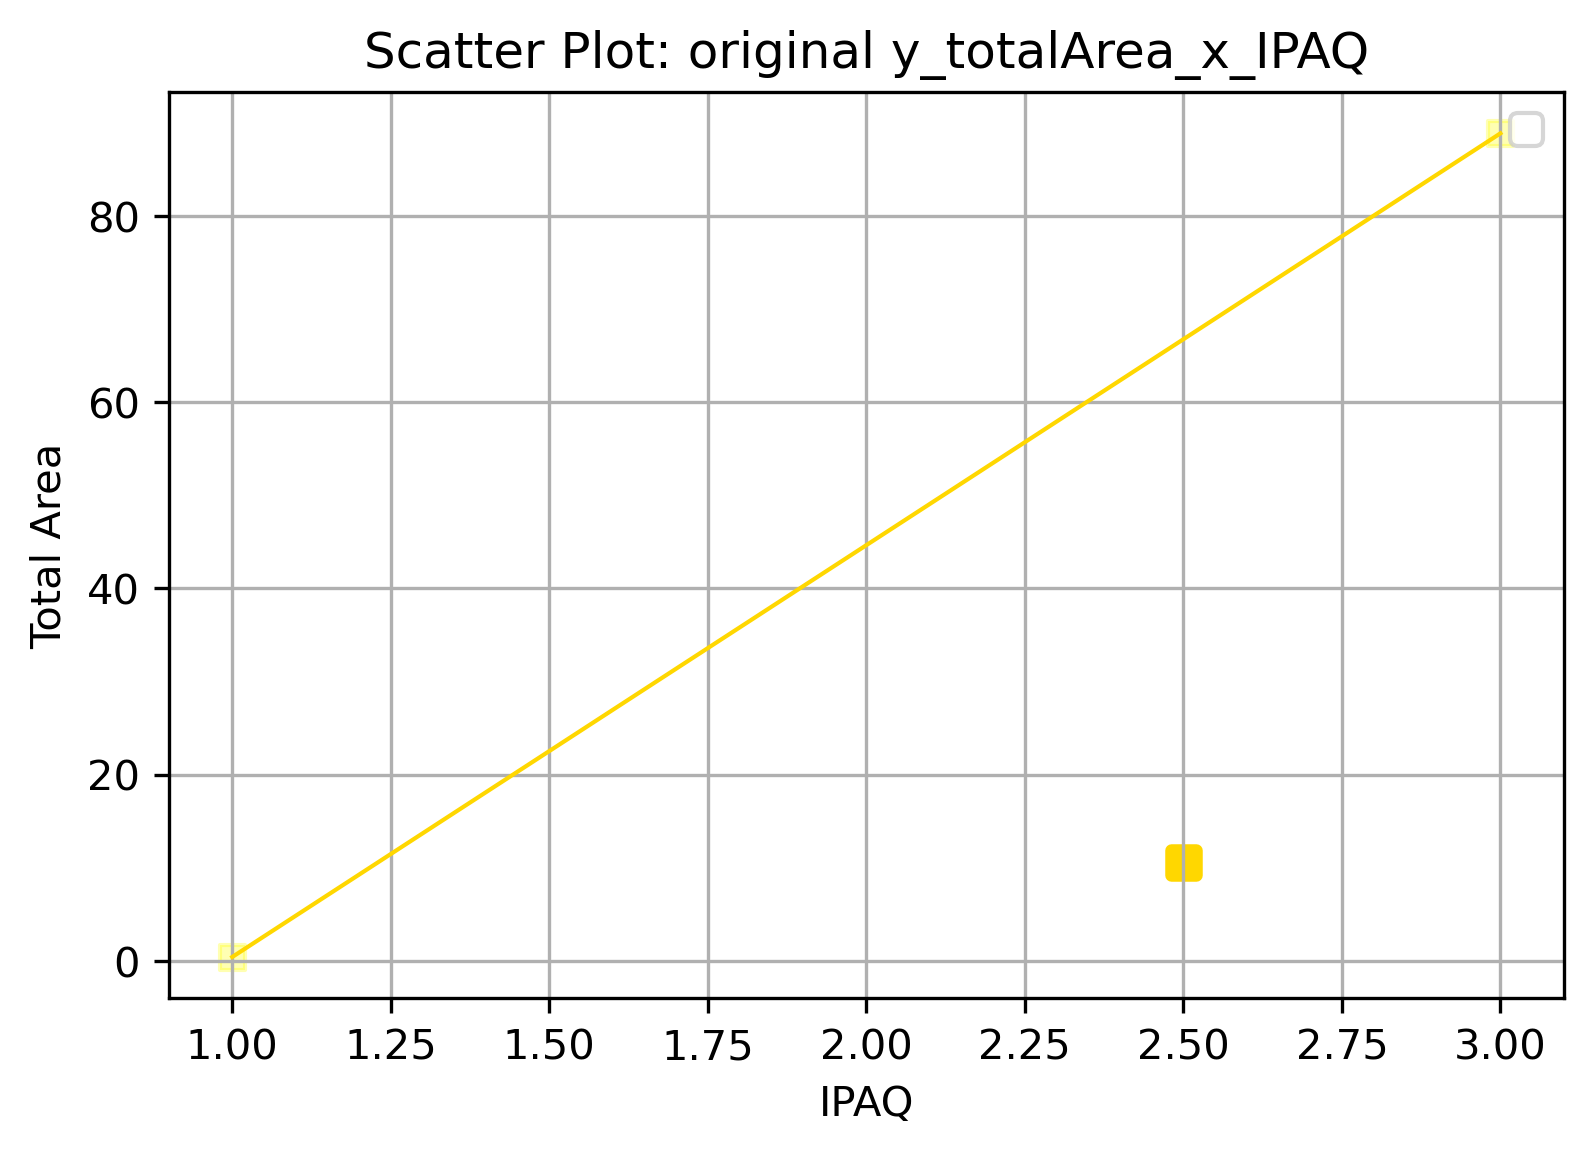

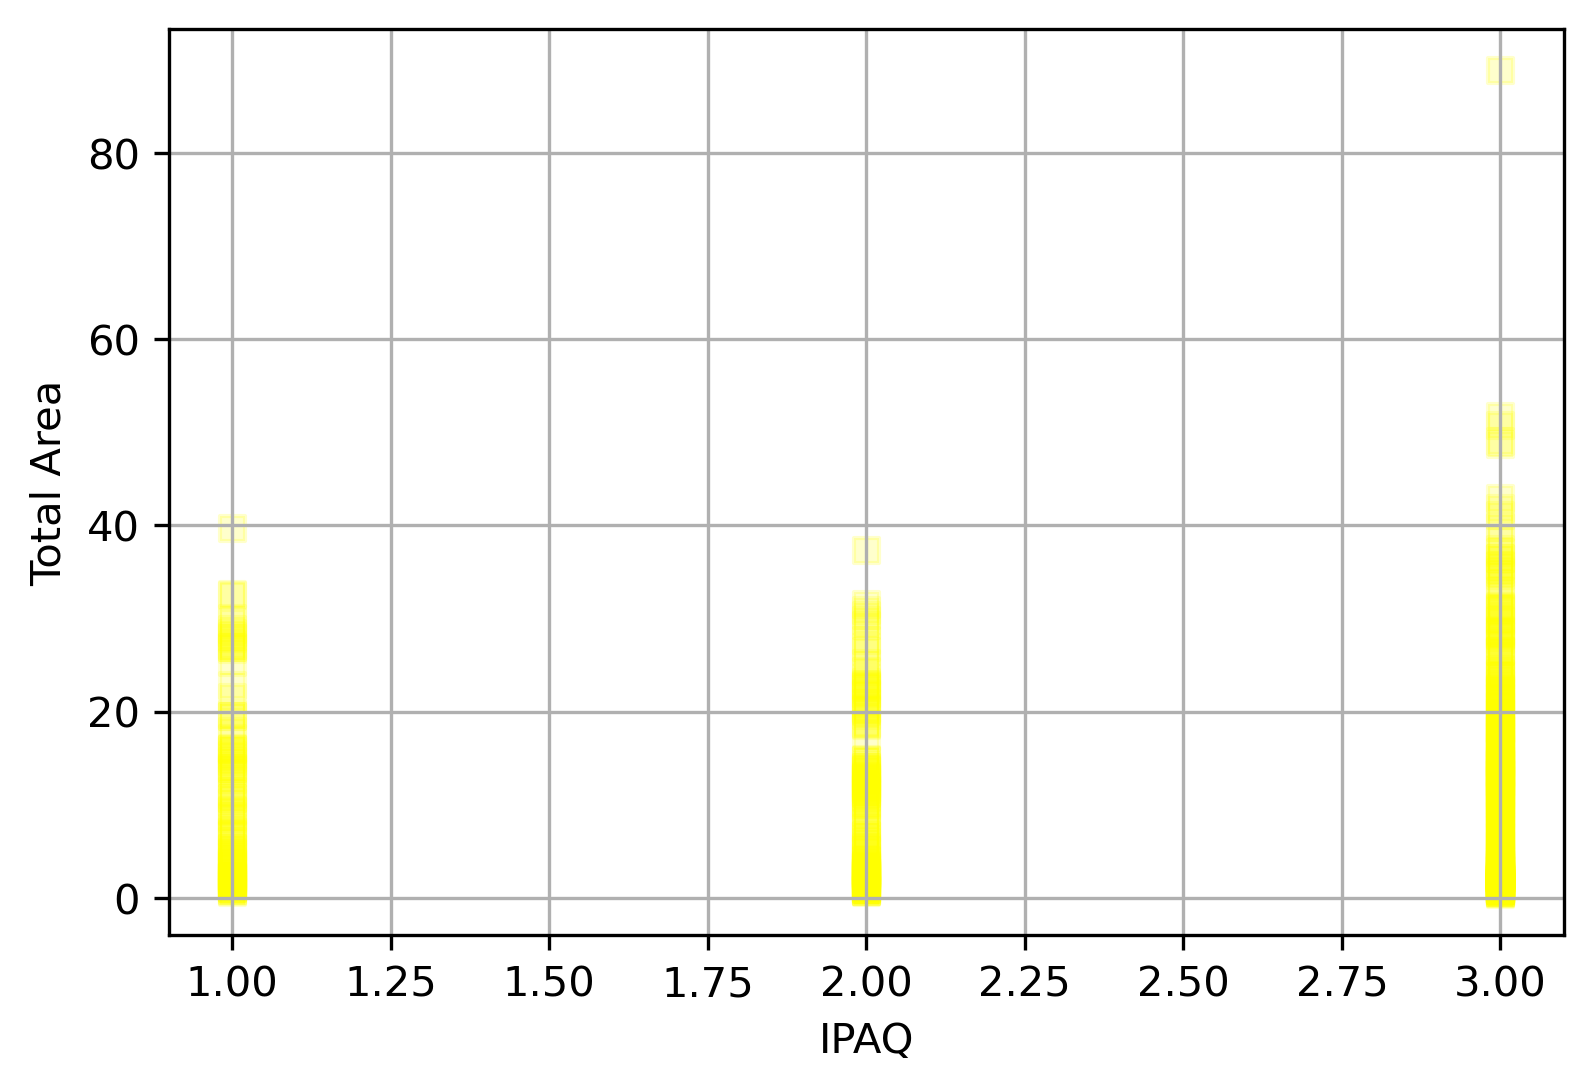


------------------ y_IPAQ_x_totalArea ------------------


No handles with labels found to put in legend.



Range: x=[0.4102078939927178, 88.87804643616839] y=[1, 3]

Mean: x=10.57034230807675 y=2.5

STD: x=10.564575995513435 y=0.7315813472236931


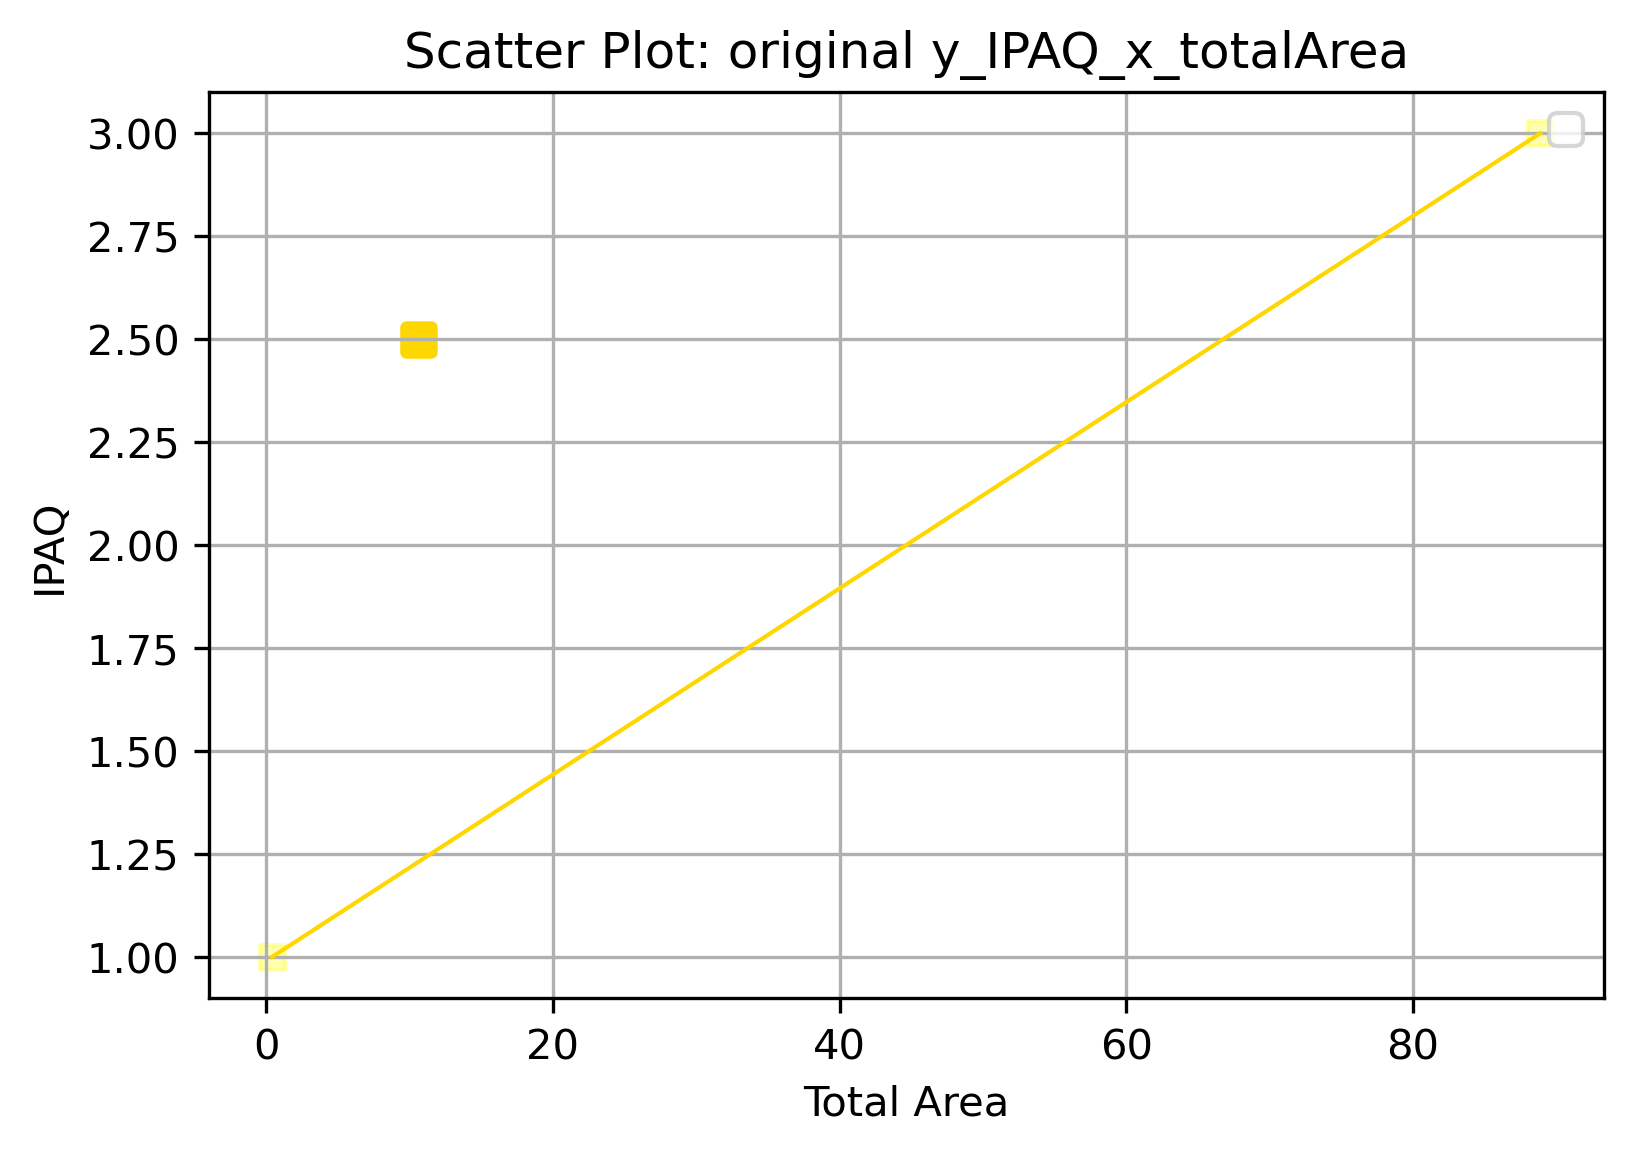

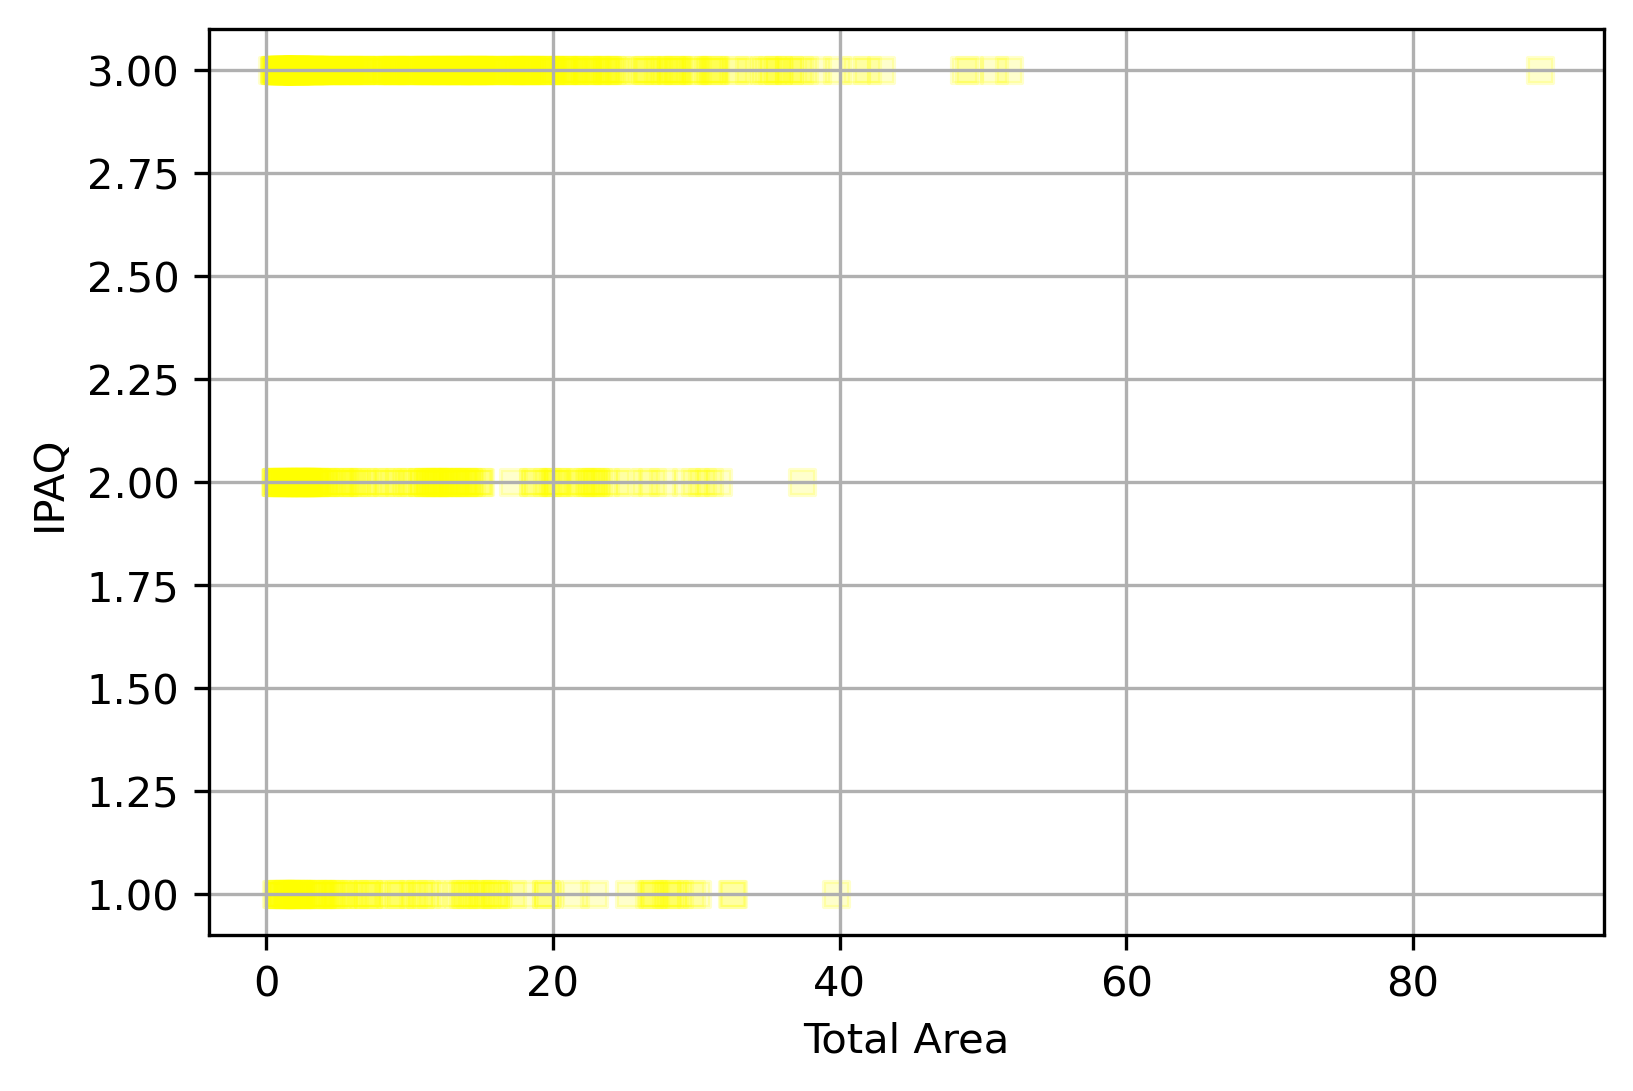


------------------ y_IPAQ ------------------

Range: x=[0.1405488996666666, 3.897583579277778] y=[1, 3]

Mean: x=1.0384700685459198 y=2.5

STD: x=0.6607561779845109 y=0.7315813472236931

Range: x=[26.01134630582536, 541.4482963049761] y=[1, 3]

Mean: x=131.0218621588279 y=2.5

STD: x=86.38056683338019 y=0.7315813472236931

Range: x=[0.4335947042144584, 9.025642545507186] y=[1, 3]

Mean: x=2.1840617129326185 y=2.5

STD: x=1.4399160999063207 y=0.7315813472236931

Range: x=[0.347529162, 9.292425413222222] y=[1, 3]

Mean: x=1.9422836695060746 y=2.5

STD: x=1.2368485414132397 y=0.7315813472236931

Range: x=[0.4102078939927178, 88.87804643616839] y=[1, 3]

Mean: x=10.570342308076757 y=2.5

STD: x=10.572839255279332 y=0.7315813472236931


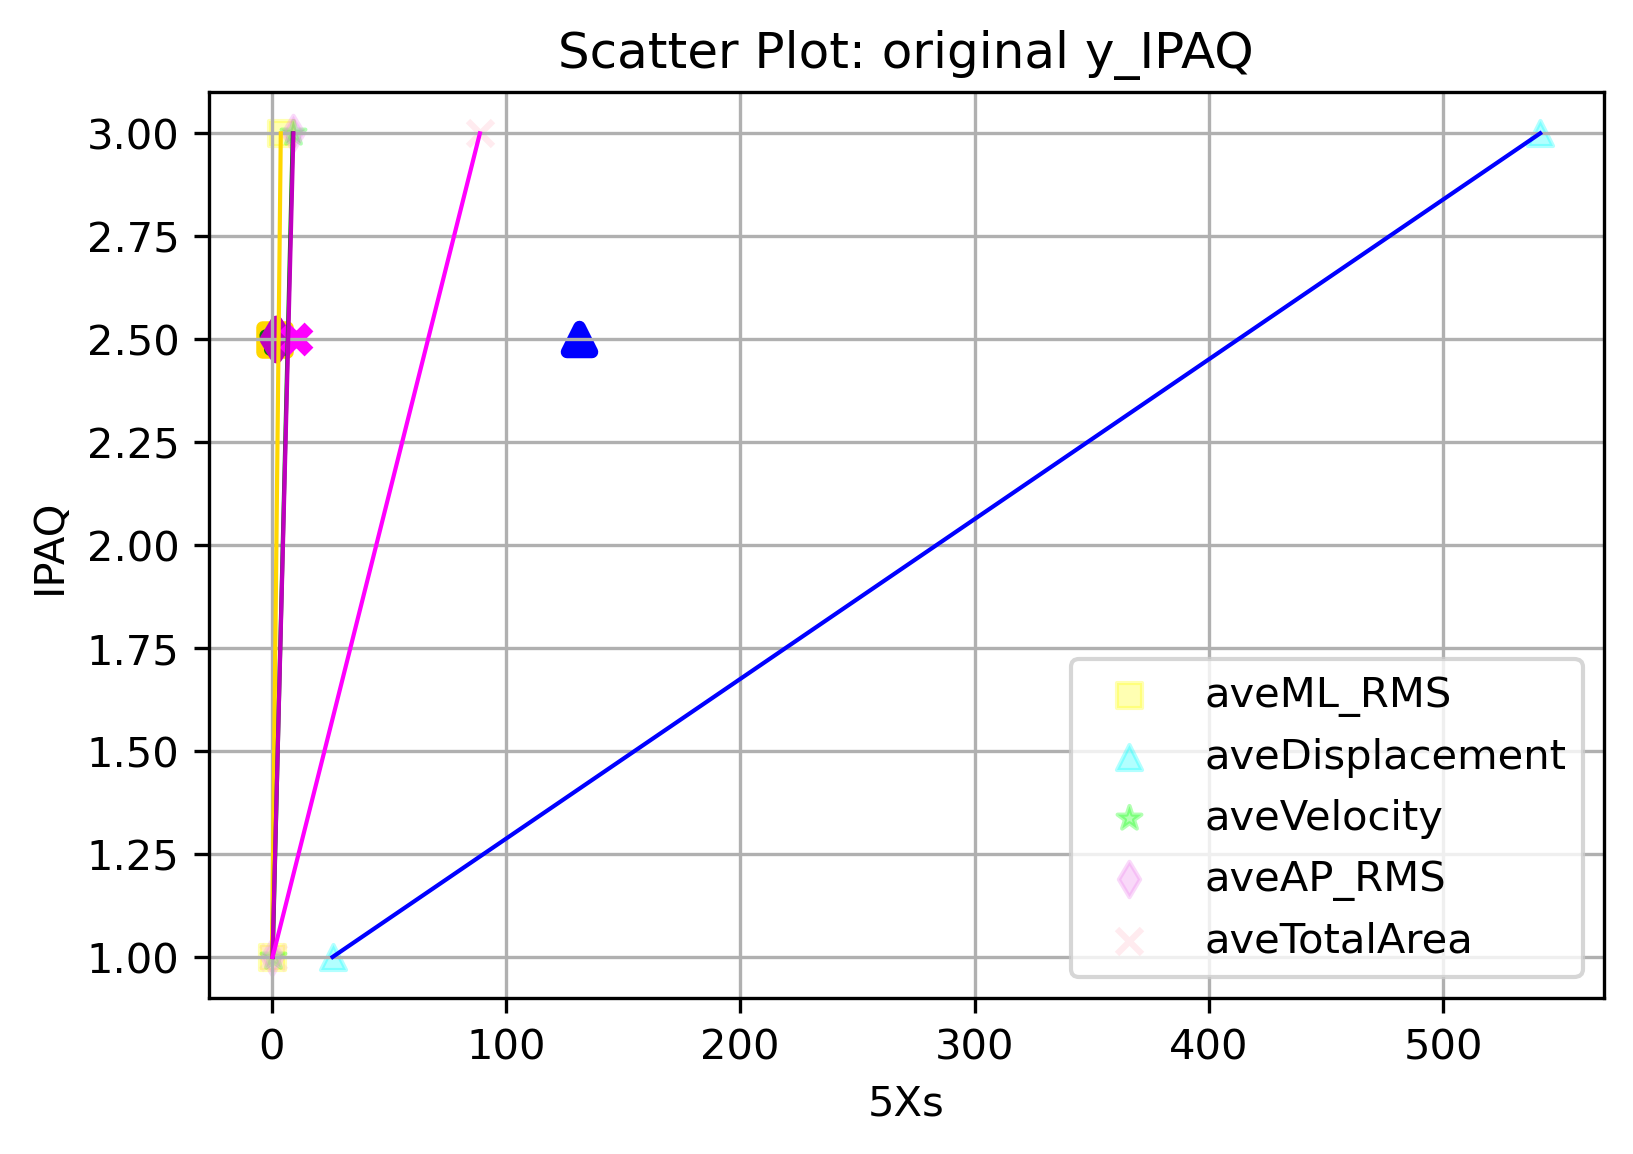

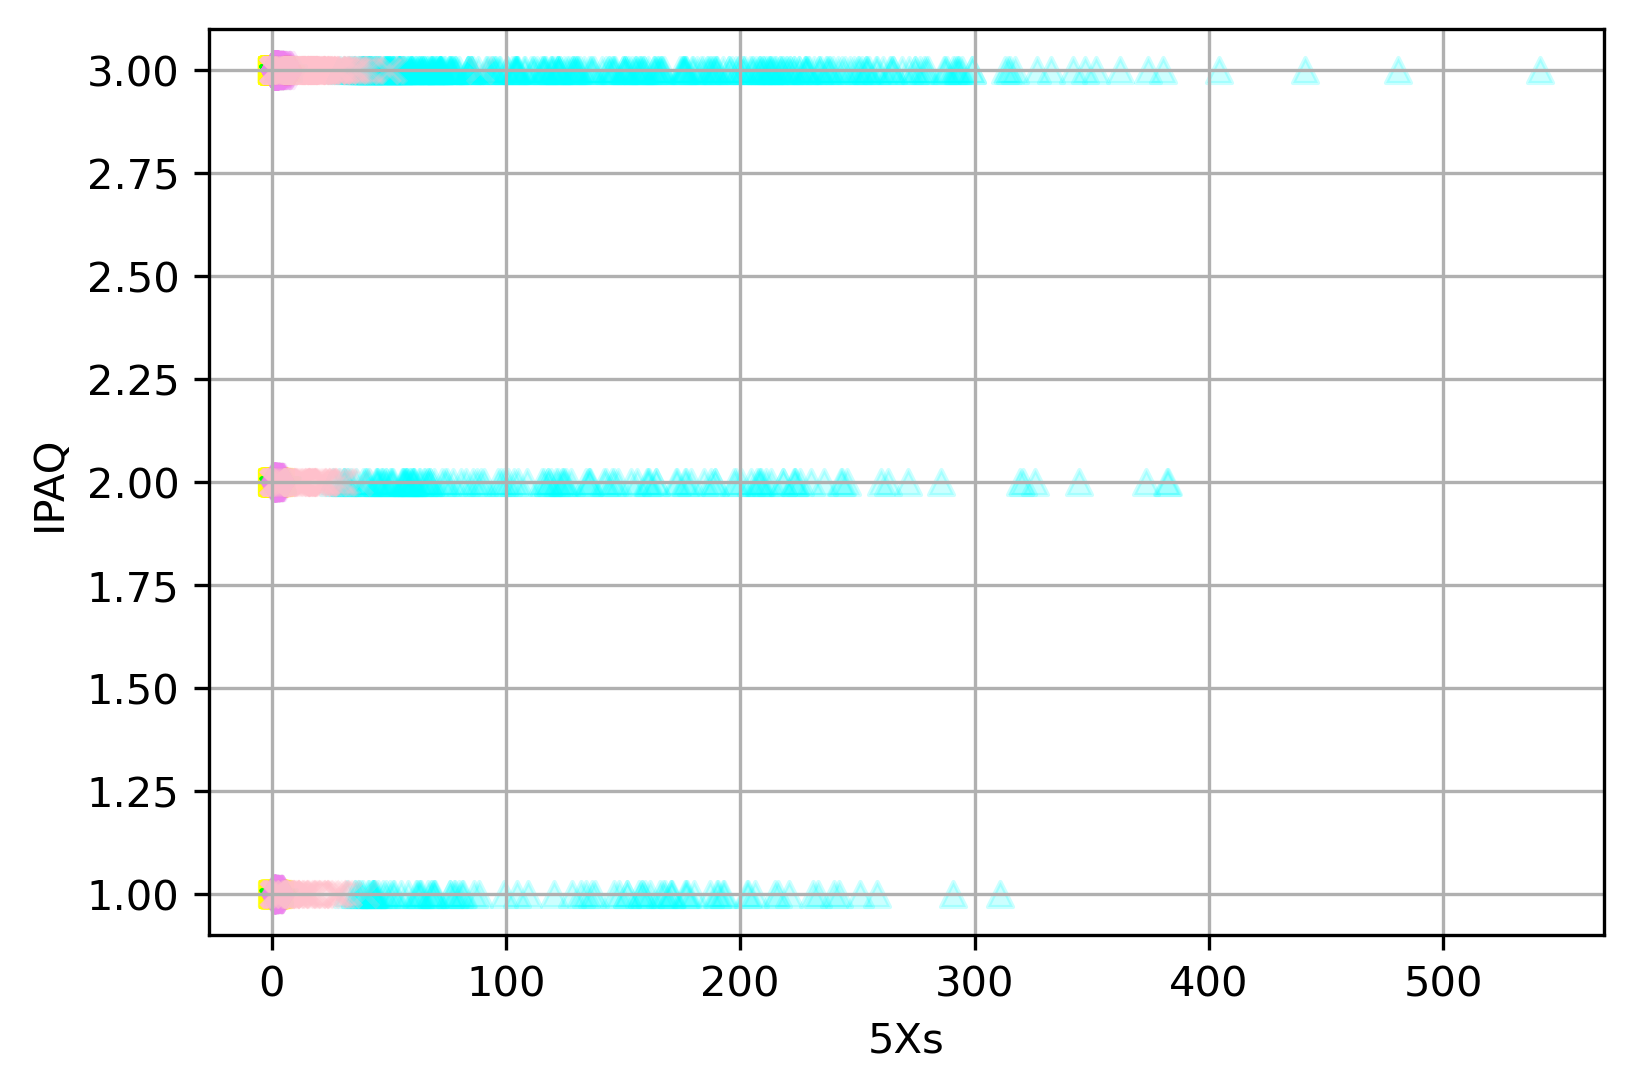


------------------ y_totalArea ------------------

Range: x=[0.1405488996666666, 3.897583579277778] y=[0.4102078939927178, 88.87804643616839]

Mean: x=1.0384700685459198 y=10.570342308076757

STD: x=0.6607561779845109 y=10.572839255279332

Range: x=[26.01134630582536, 541.4482963049761] y=[0.4102078939927178, 88.87804643616839]

Mean: x=131.0218621588279 y=10.570342308076757

STD: x=86.38056683338019 y=10.572839255279332

Range: x=[0.4335947042144584, 9.025642545507186] y=[0.4102078939927178, 88.87804643616839]

Mean: x=2.1840617129326185 y=10.570342308076757

STD: x=1.4399160999063207 y=10.572839255279332

Range: x=[0.347529162, 9.292425413222222] y=[0.4102078939927178, 88.87804643616839]

Mean: x=1.9422836695060746 y=10.570342308076757

STD: x=1.2368485414132397 y=10.572839255279332

Range: x=[0, 5040] y=[0.4102078939927178, 88.87804643616839]

Mean: x=550.875 y=10.570342308076757

STD: x=673.5858193467549 y=10.572839255279332

Range: x=[1, 3] y=[0.4102078939927178, 88.8780464361683

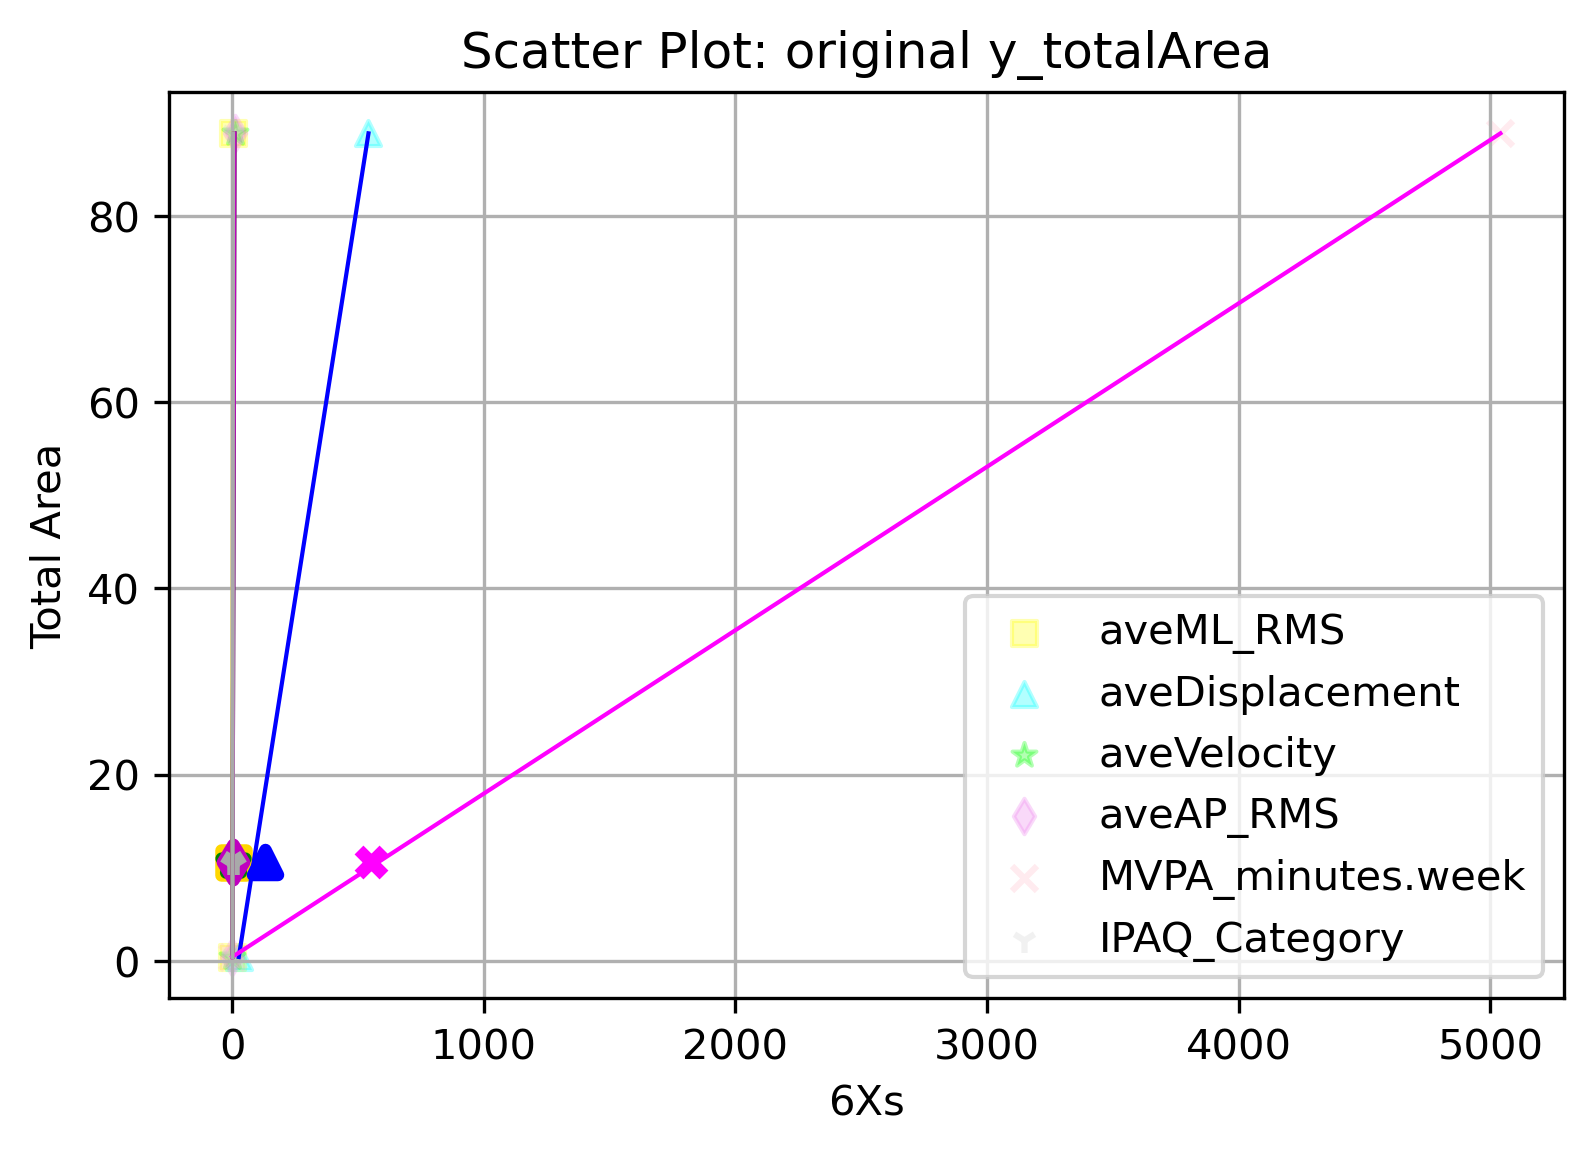

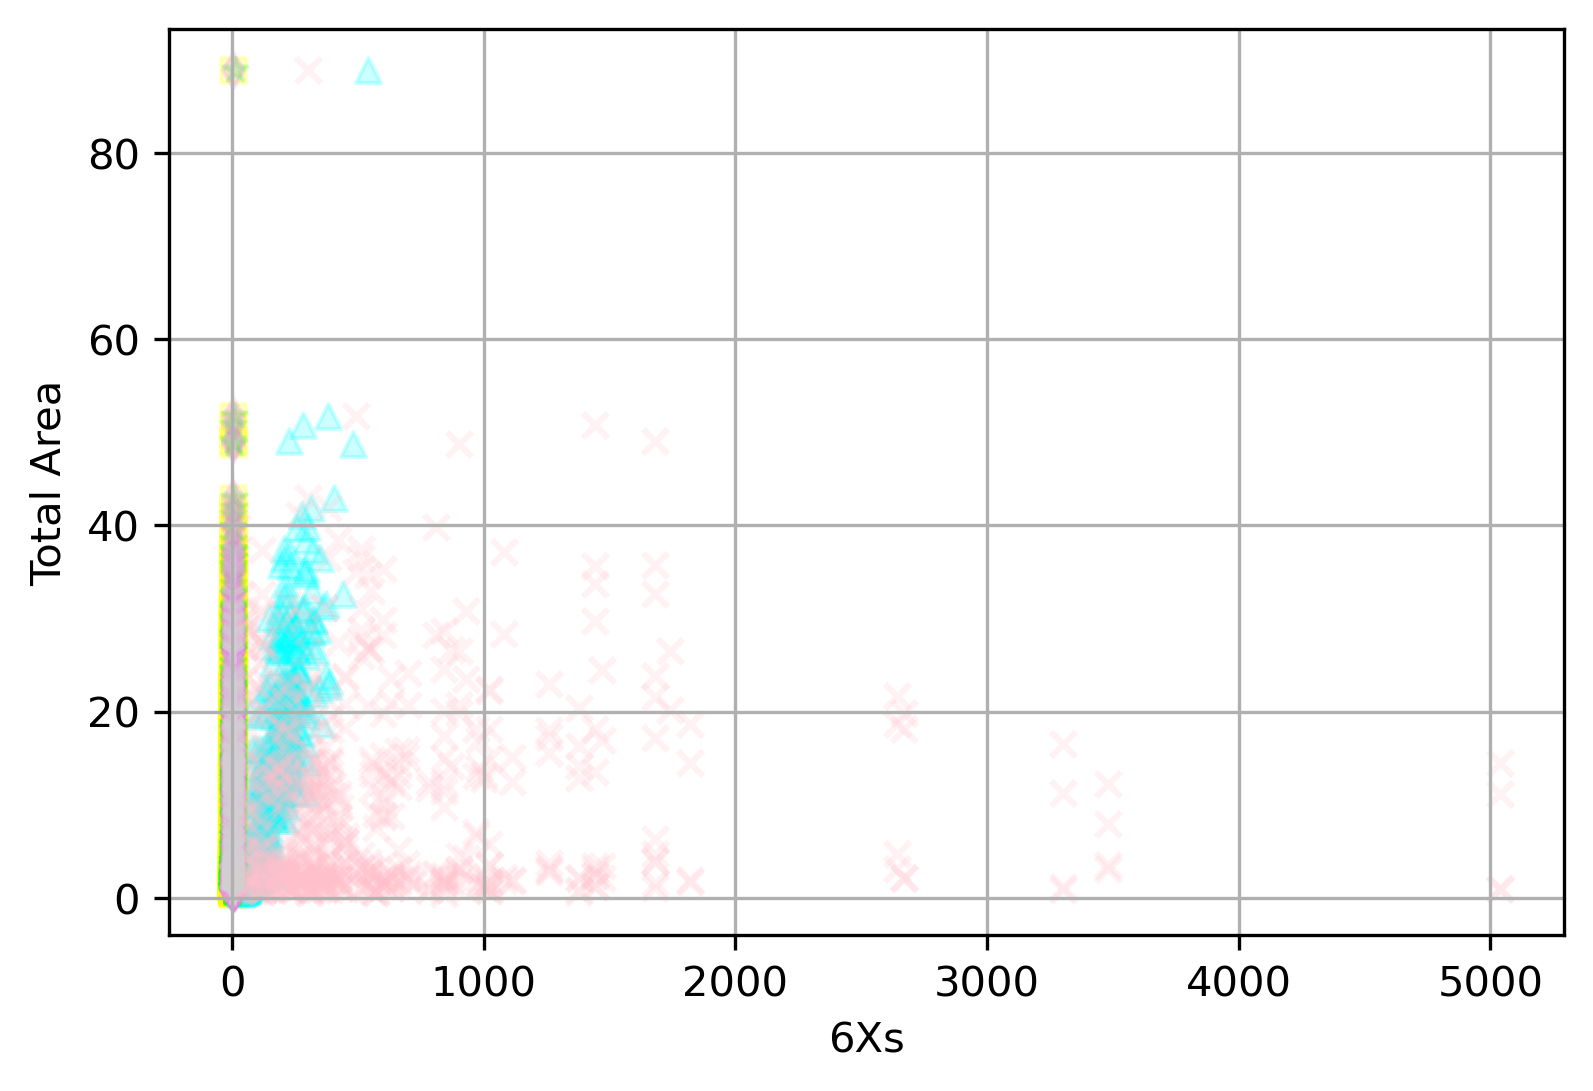

In [27]:
if __name__ == '__main__':
    checks = ['y_totalArea_x_MVPA', 'y_MVPA_x_totalArea', 'y_MVPA',
             'y_totalArea_x_IPAQ', 'y_IPAQ_x_totalArea', 'y_IPAQ',
             'y_totalArea']
    loadfile = '/BDS/variables.xlsx'
    savefile = '/original'
    
    for check in checks:
        print("\n------------------ %s ------------------" %check)
        test = plot1(check, loadfile, savefile)
        test.scatter()